# read csv file and plot the data measured from TS600 tensile stage using python script


In [426]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(axis='both',which='minor', direction='out',width=1, length=2)  # Adjust size as needed
    #axs.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.minorticks_on()  # Enable minor ticks
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)
    return axs

In [427]:
import os
from cv2 import line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



def plot_force_temperature_distance(base_path, file_keyword, T_hold_time= 140 ,temp_ylim=(25, 35), figsize=(8, 6), dpi=300):
    """
    Plots Force and Temperature vs. Time with a top axis showing Distance.

    Parameters:
    - base_path (str): Directory containing the Excel files
    - file_keyword (str): Substring to match in the filename (e.g., 'LDPE_30C')
    - temp_ylim (tuple): Y-axis limits for temperature
    - figsize (tuple): Size of the figure
    - dpi (int): Resolution of the figure
    """

    # === Locate the File ===
    matching_files = [f for f in os.listdir(base_path) if file_keyword in f and f.endswith('.xlsx')]
    if not matching_files:
        raise FileNotFoundError(f"No Excel file containing '{file_keyword}' found in {base_path}")
    
    excel_path = os.path.join(base_path, matching_files[0])
    print(f"📄 Using file: {matching_files[0]}")

    # === Load Excel and Detect Header ===
    raw_df = pd.read_excel(excel_path, header=None)
    header_row = next(i for i, row in raw_df.iterrows() if row.astype(str).str.contains('Index').any())

    # Read the actual data using the detected header row
    df = pd.read_excel(excel_path, header=header_row + 1)

    # === Extract Columns of Interest ===
    time = df.iloc[:, 1].astype(float)
    temperature = df.iloc[:, 2].astype(float)
    force = df.iloc[:, 4].astype(float)
    distance = df.iloc[:, 6].astype(float)

    # === Create the Plot ===
    fig, ax_force = plt.subplots(figsize=figsize, dpi=dpi)

    force_color = 'tab:red'
    temp_color = 'tab:blue'

    # Plot Force vs Time
    ax_force.plot(time, force, color=force_color, label='Force')
    set_plot_style(ax_force, 20, 'Time [s]', 'Force[N]')
    ax_force.tick_params(axis='y', labelcolor=force_color)
    ax_force.set_ylabel('Force [N]', color=force_color)
    # set x limits
    ax_force.set_xlim(0, 1600)

    # Plot Temperature vs Time on Secondary Y-axis
    ax_temp = ax_force.twinx()
    ax_temp.plot(time, temperature, color=temp_color, label='Temperature')
    # verticlal line for T_hold_time
    ax_temp.axvline(x=T_hold_time, color='gray', linestyle='--', label='Tensile test start', linewidth=1.5)
    set_plot_style(ax_temp, 20, 'Time [s]', 'Temperature [°C]')
    ax_temp.set_ylabel('Temperature [°C]', color=temp_color)
    ax_temp.tick_params(axis='y', labelcolor=temp_color)
    ax_temp.set_ylim(temp_ylim)
    ax_temp.grid(False)

    # Add Top X-axis for Distance
    ax_dist = ax_force.twiny()
    ax_dist.set_xlim(ax_force.get_xlim())
    time_ticks = ax_force.get_xticks()
    distance_ticks = np.interp(time_ticks, time, distance)
    ax_dist.set_xticks(time_ticks)
    ax_dist.set_xticklabels([f"{d:.1f}" for d in distance_ticks])
    ax_dist.set_xlabel('Distance [µm]')
    set_plot_style(ax_dist, 20,'Distance [µm]', '')
    ax_dist.grid(False)

    # Combine and Display Legend
    lines_force, labels_force = ax_force.get_legend_handles_labels()
    lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
    ax_force.legend(lines_force + lines_temp, labels_force + labels_temp, loc='lower right', fontsize=20)

    plt.tight_layout()
    plt.show()


## Sample 

📄 Using file: Run8_LDPE_30C_50ums 24-05-25 15-57-17-57Exported.xlsx


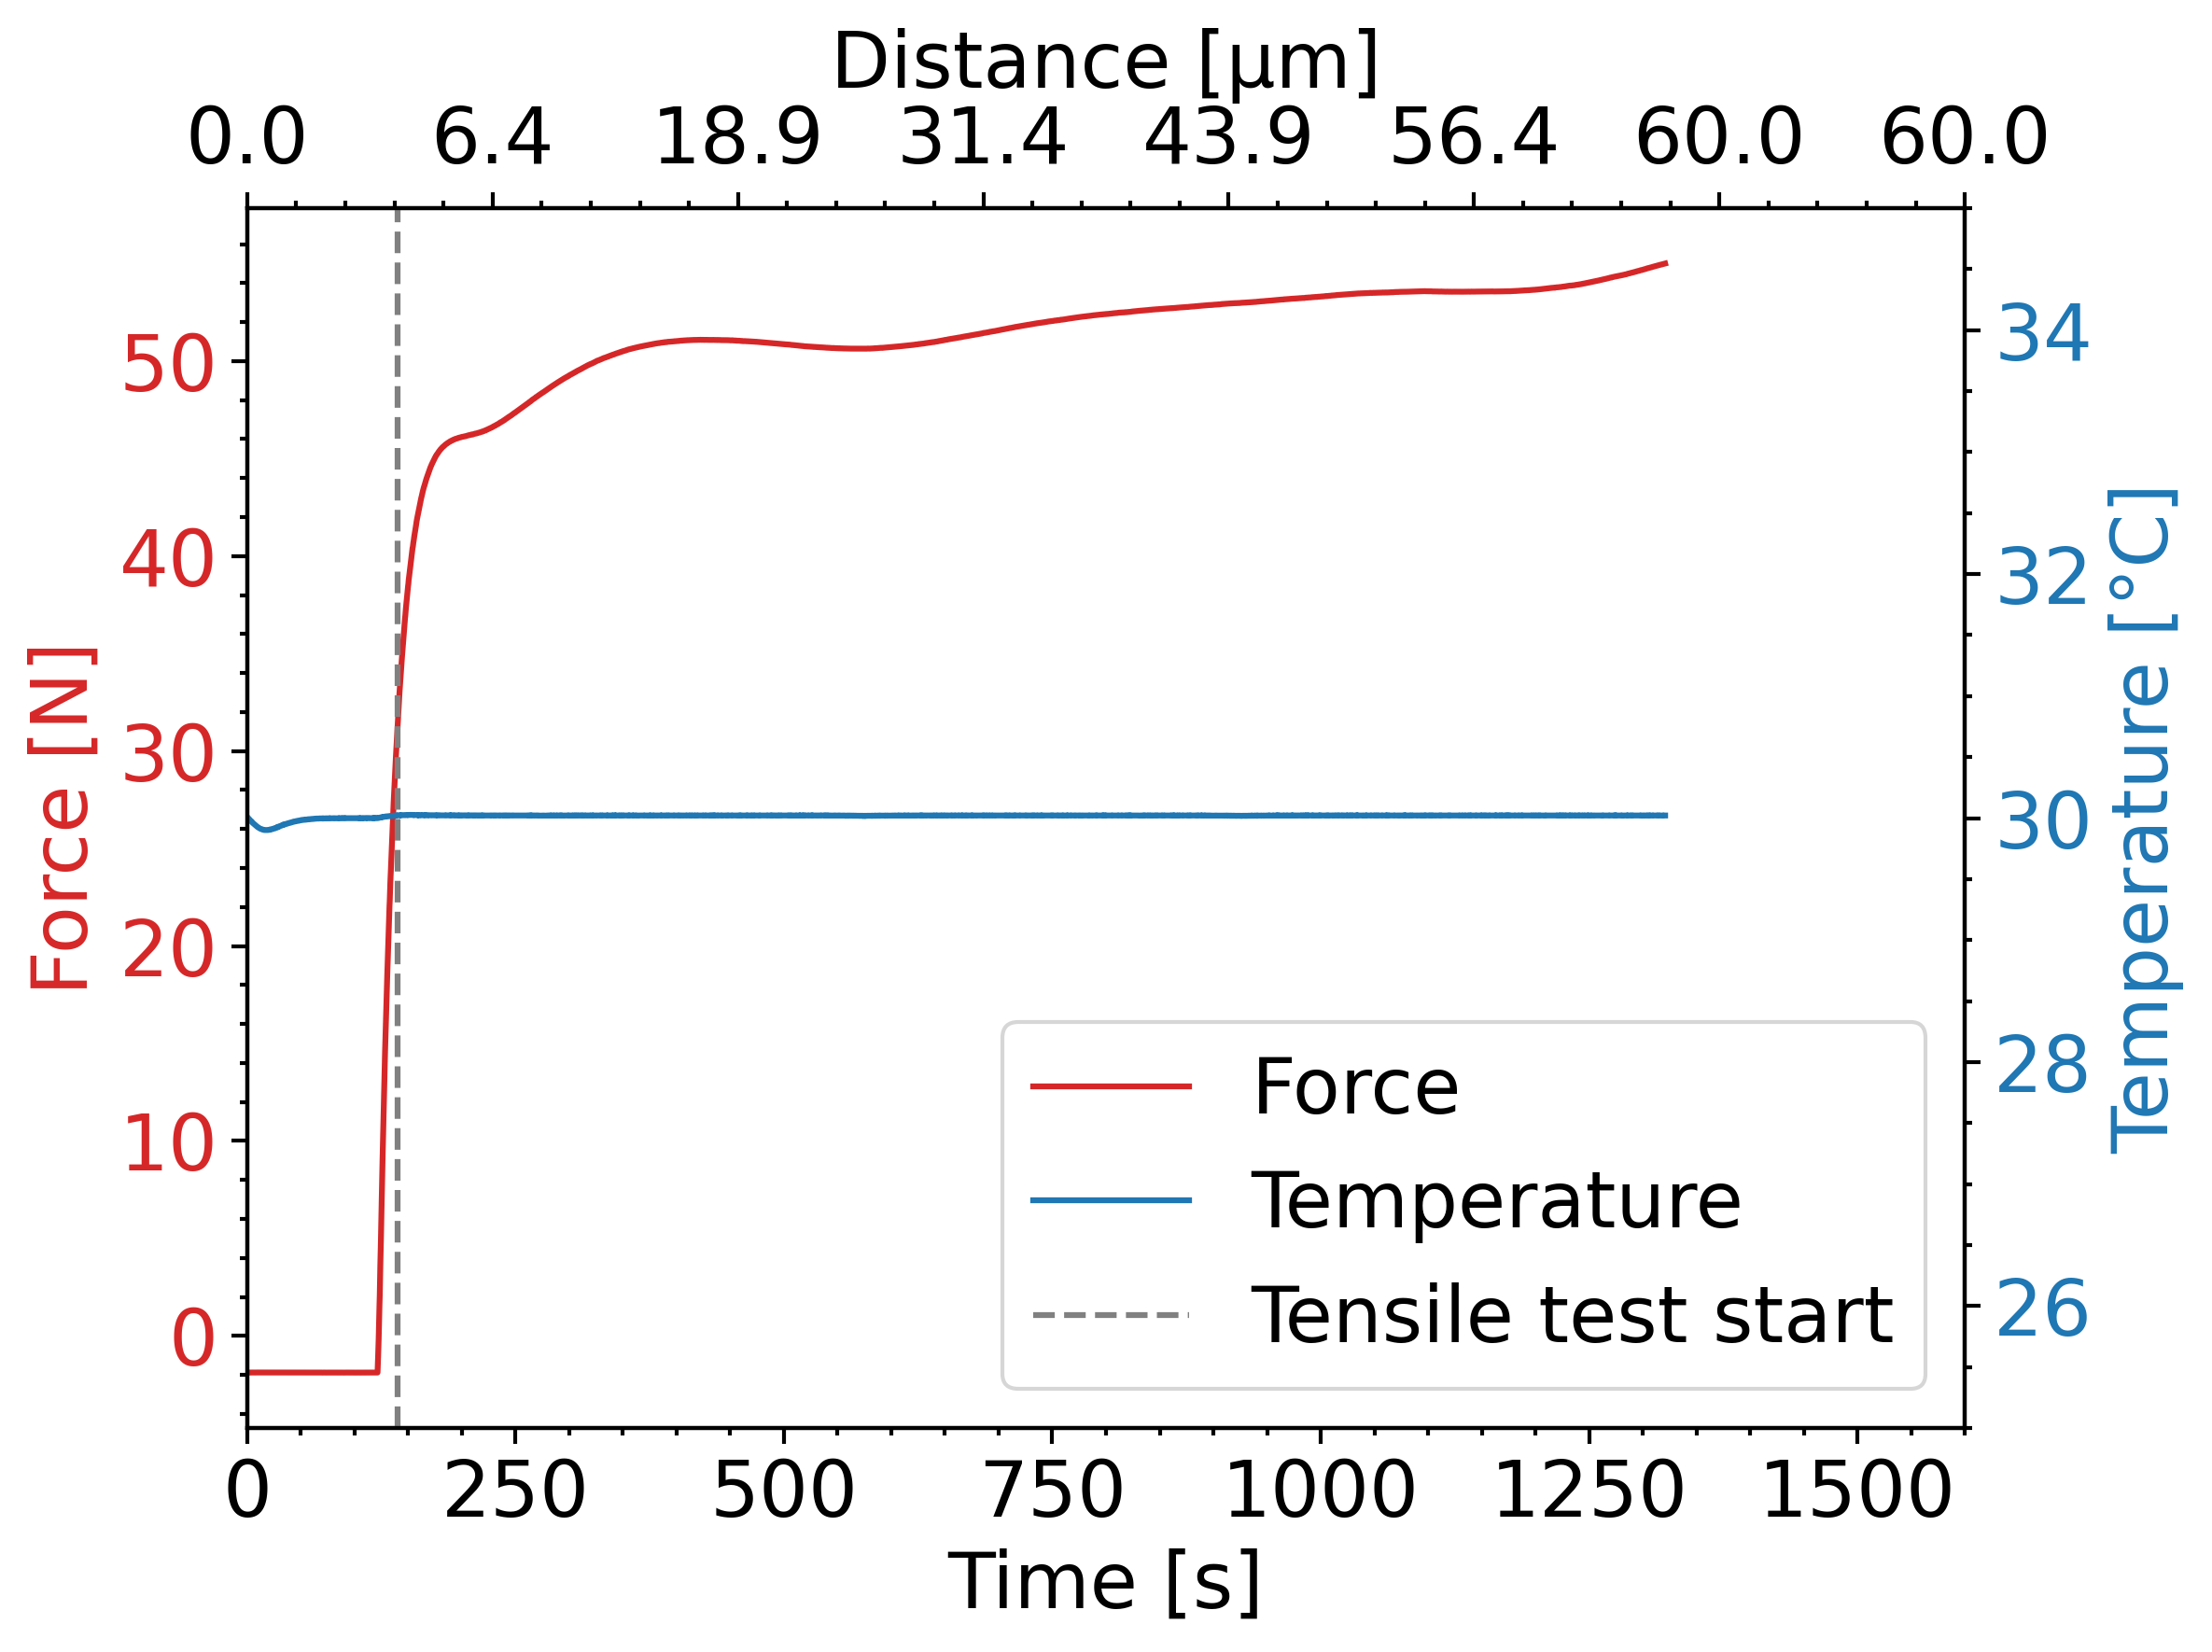

📄 Using file: Run14_LDPE_50C_50ums 24-05-25 19-44-32-94Exported.xlsx


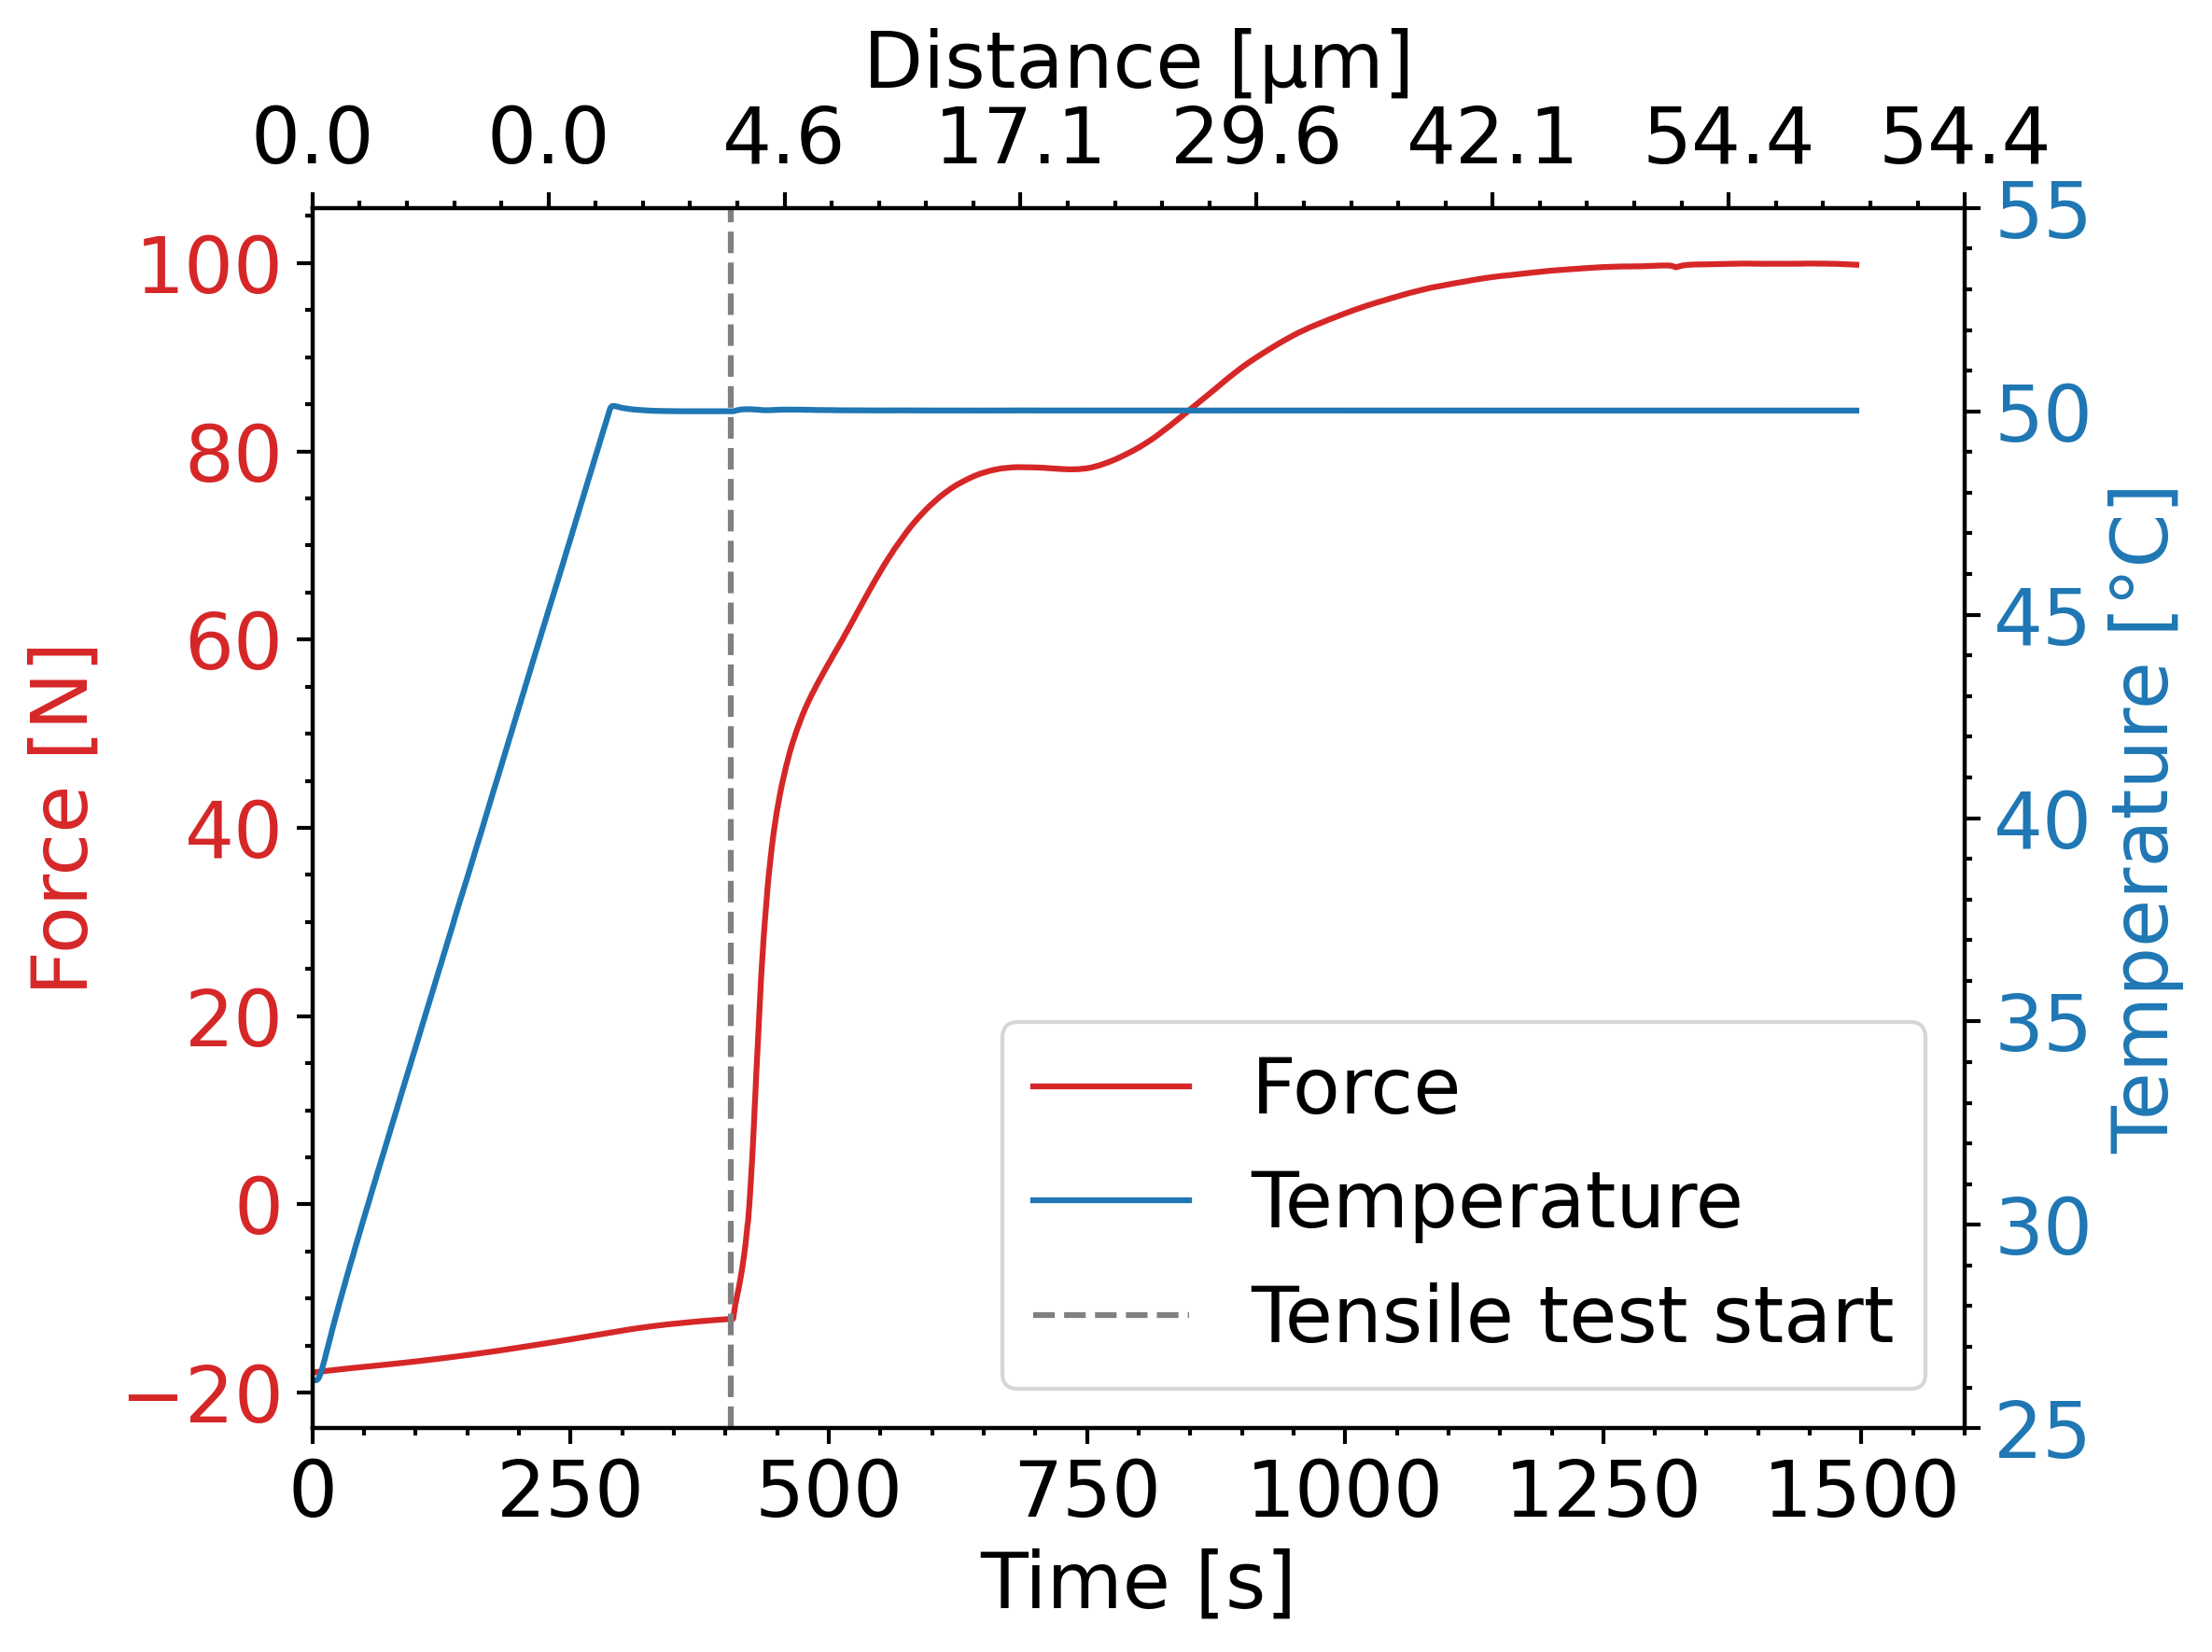

📄 Using file: Run6_LDPE_75C_50ums 24-05-25 14-09-03-47Exported.xlsx


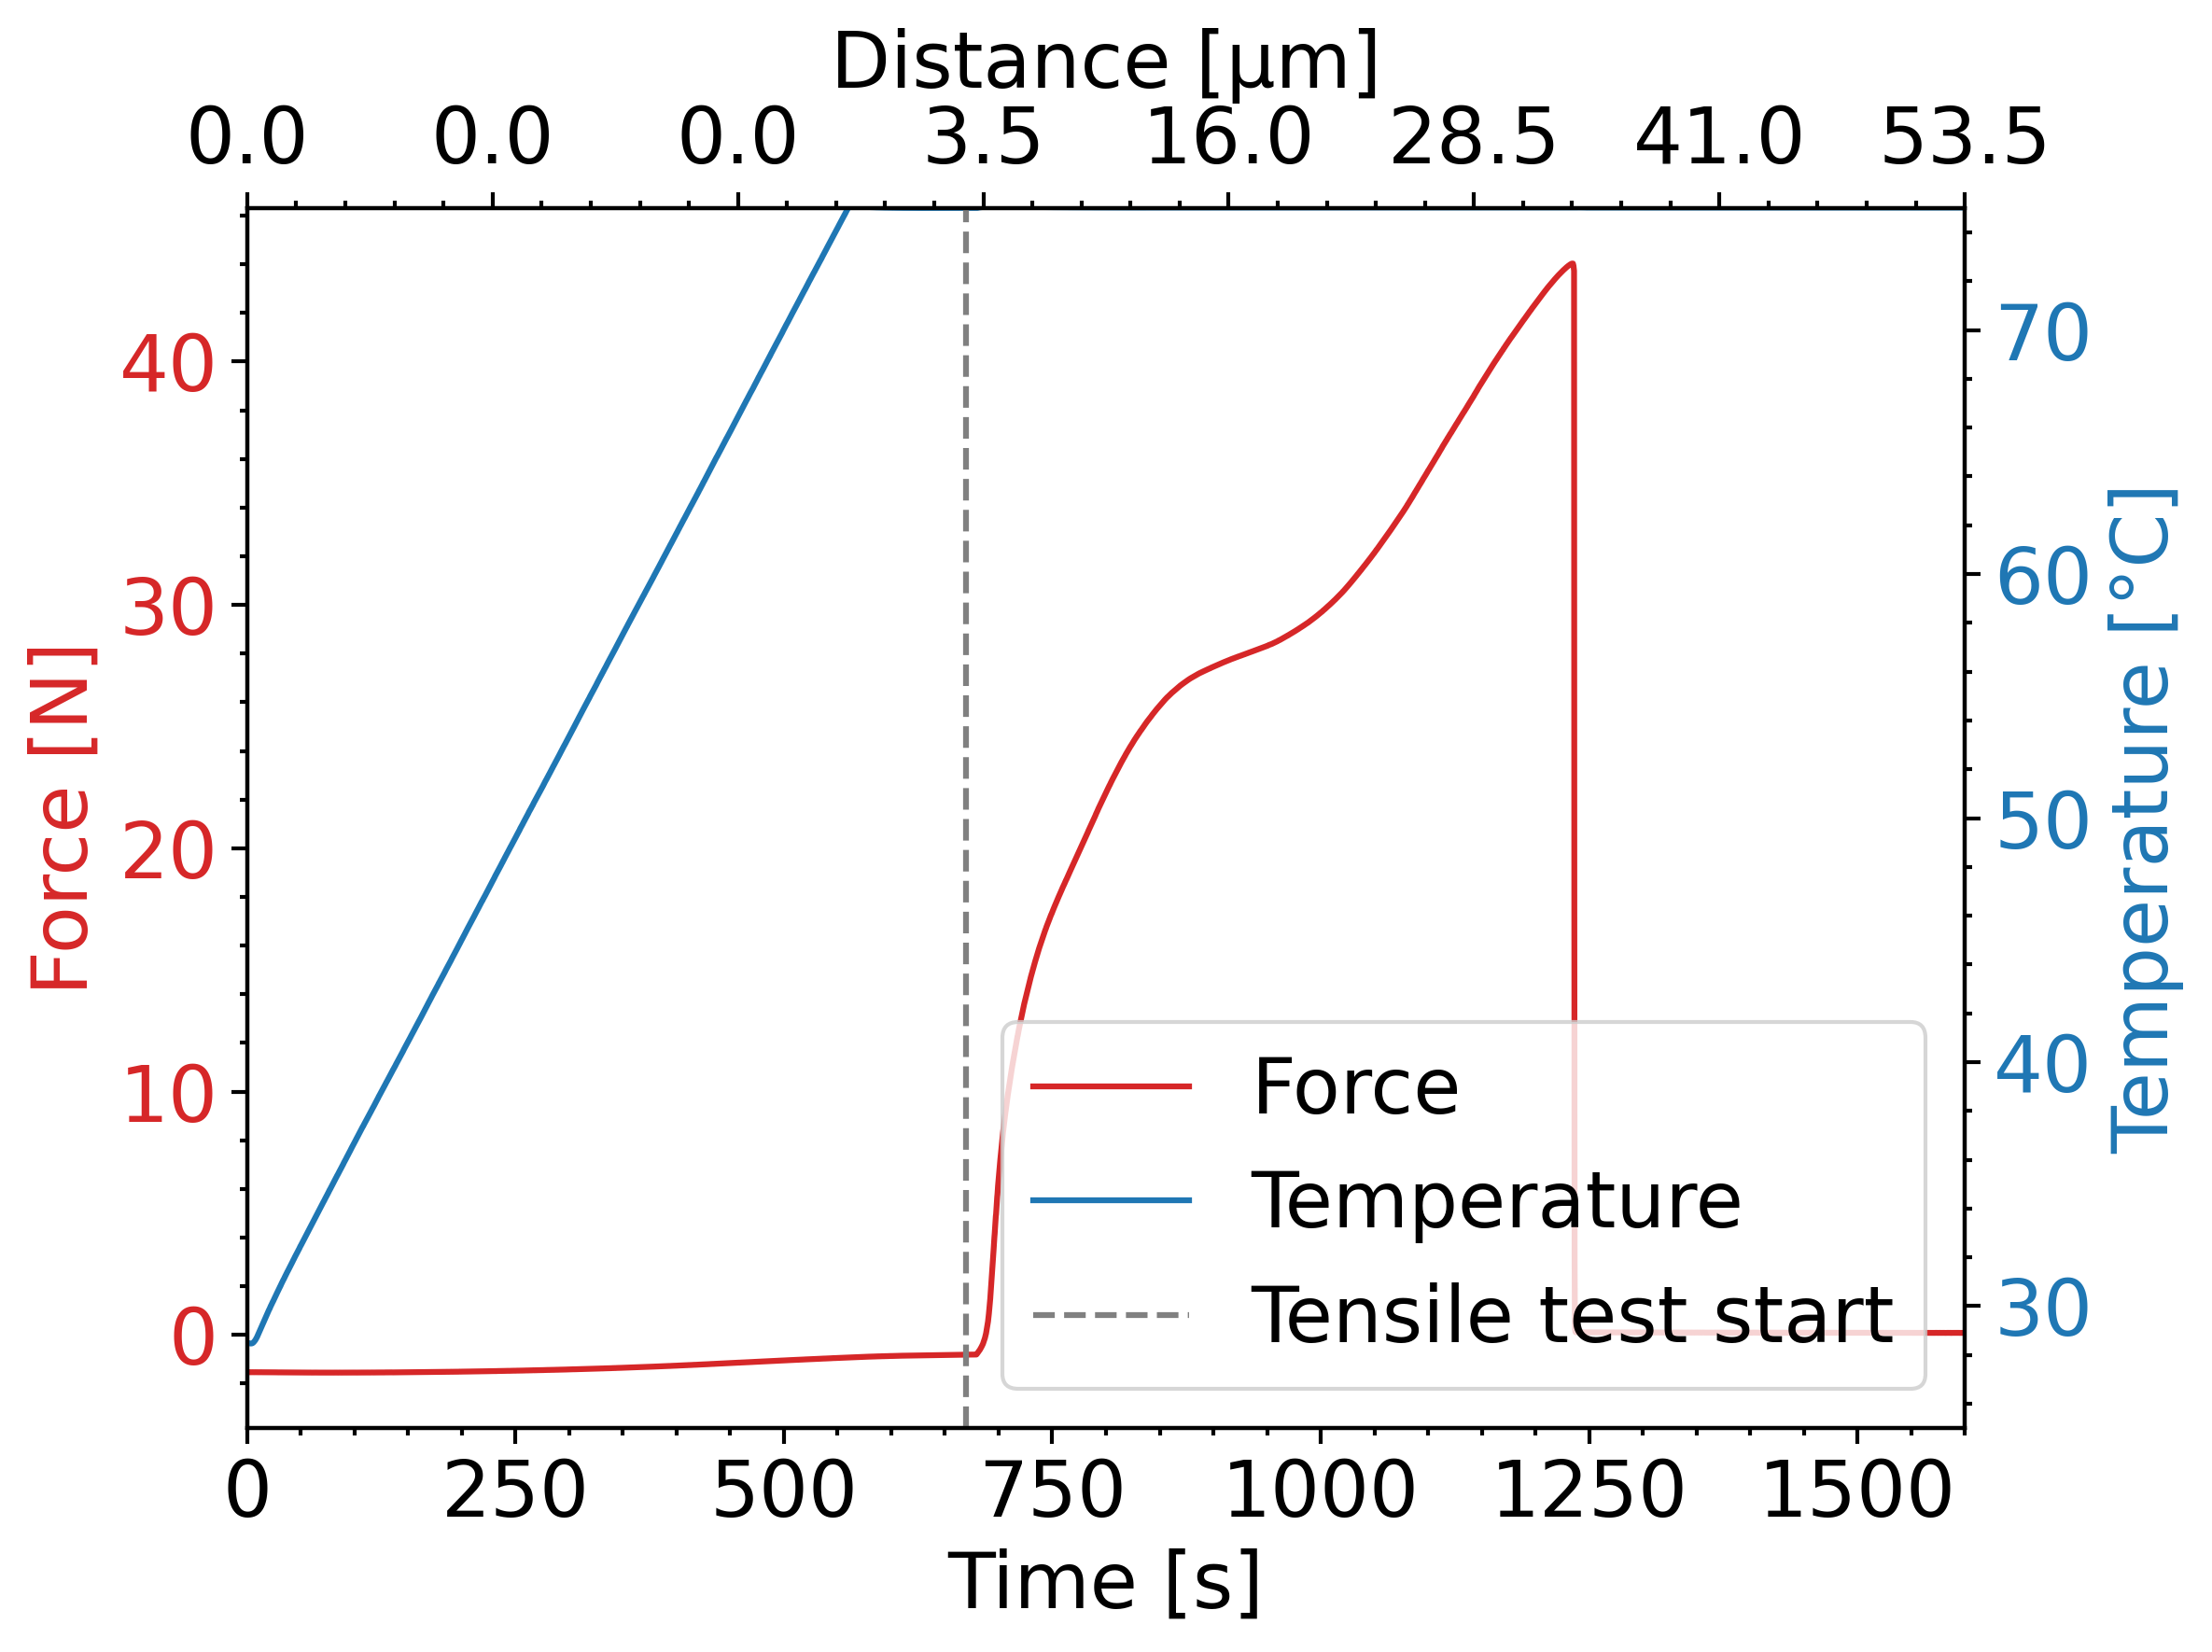

📄 Using file: Run16_LDPE_100C_50ums 24-05-25 20-55-23-90Exported.xlsx


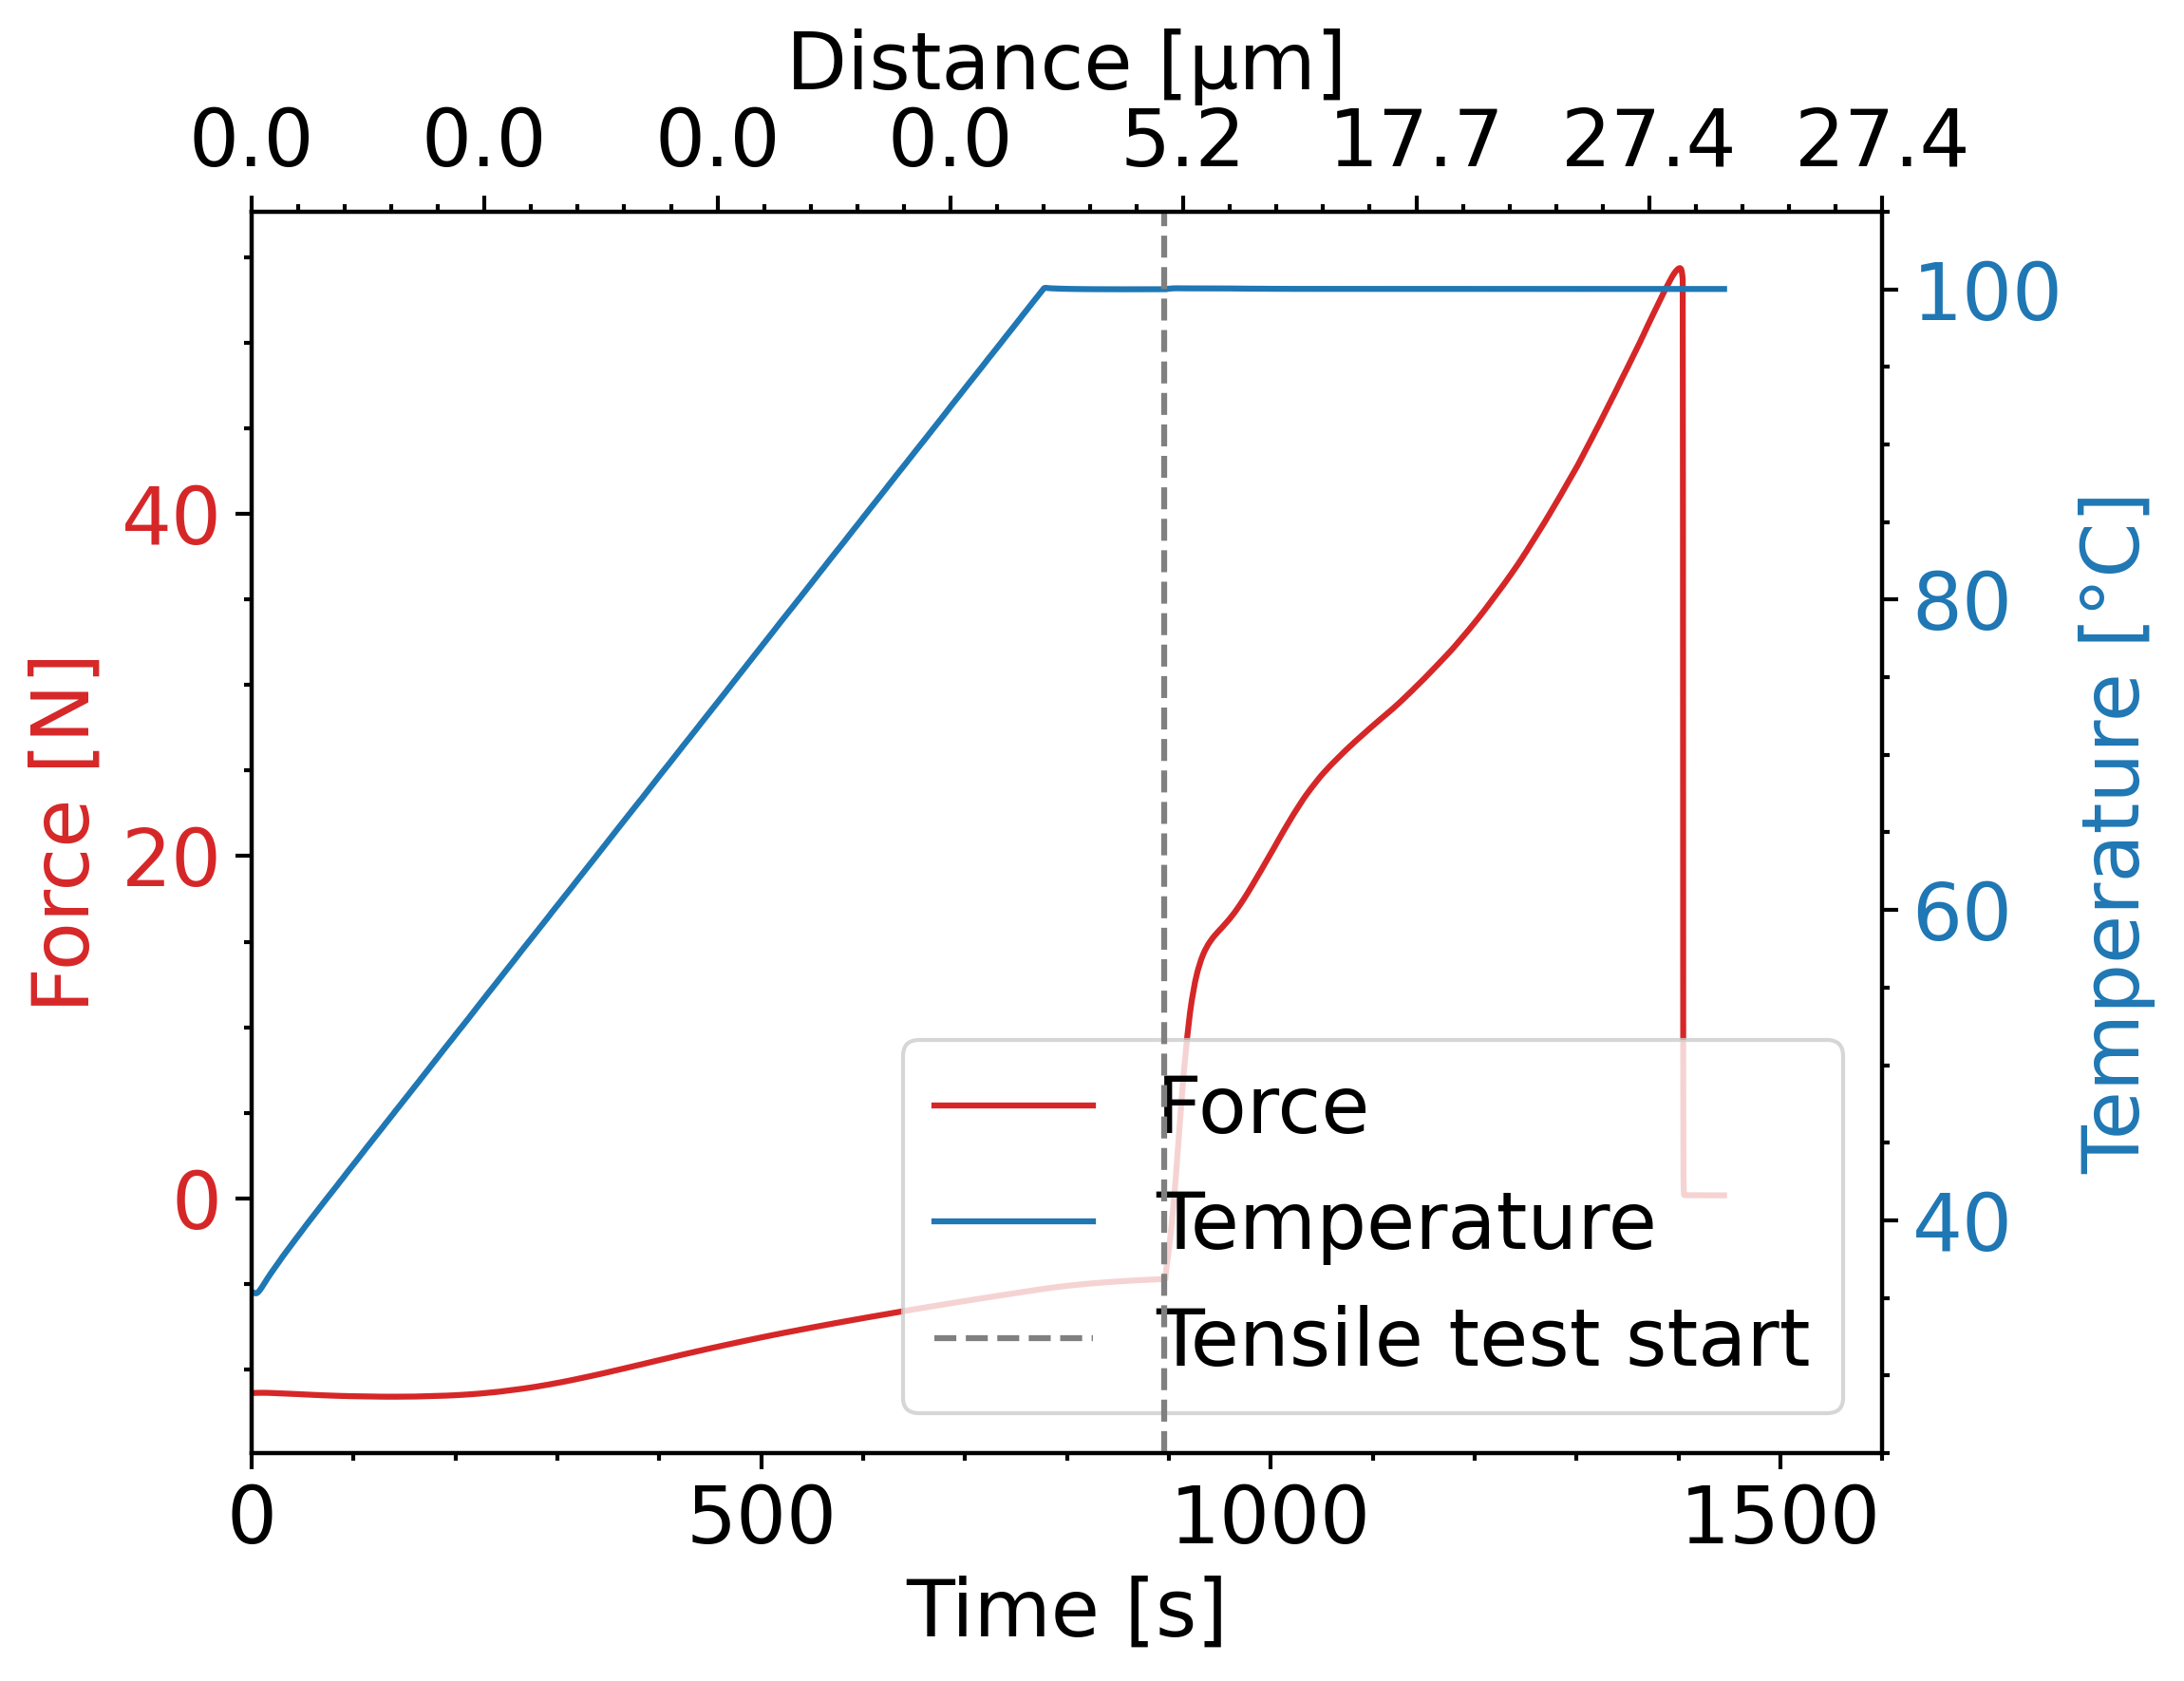

In [428]:
from matplotlib.pyplot import plot


base_path=r"/Users/akmaurya/OneDrive - Stanford/Data_01/Redesigned_Plastics/May_2025/linkam_stage/tensile_temperature_data"
    
plot_force_temperature_distance(base_path=base_path, file_keyword="Run8_LDPE_30C", T_hold_time=140, temp_ylim=(25, 35), figsize=(8, 6), dpi=300)
plot_force_temperature_distance(base_path=base_path, file_keyword="LDPE_50C", T_hold_time=405, temp_ylim=(25, 55), figsize=(8, 6), dpi=300)
plot_force_temperature_distance(base_path=base_path, file_keyword="LDPE_75C", T_hold_time=670, temp_ylim=(25, 75), figsize=(8, 6), dpi=300)
plot_force_temperature_distance(base_path=base_path, file_keyword="LDPE_100C", T_hold_time=895, temp_ylim=(25, 105), figsize=(8, 6), dpi=300)



# Funtions: force vs. displacement 

## activation energy plot fucntion

In [429]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.ticker as ticker  # Required for scientific notation

def activation_energy(stress_target_all, temperature_all, dpi=300):
    """
    Plot ln(stress) vs 1/Temperature and calculate activation energy (Ea) with statistical metrics.
    
    Parameters:
        stress_target_all (list): Stress values at target elongation [MPa]
        temperature_all (list): Corresponding temperatures [°C]
        dpi (int): Plot resolution (default: 100)

    Returns:
        dict: Contains Ea, slope, intercept, r_value, chi2, reduced_chi2, and n
    """
    R = 8.314  # J/mol·K
    temperature_kelvin = np.array(temperature_all, dtype=float) + 273.15

    # Data validation and transformation
    valid_pairs = [(1/T, np.log(stress)) 
                   for T, stress in zip(temperature_kelvin, stress_target_all)
                   if T > 0 and stress > 0]
    
    if not valid_pairs:
        raise ValueError("No valid temperature-stress pairs for analysis")

    inv_temps, ln_stresses = zip(*valid_pairs)
    inv_temps = np.array(inv_temps)
    ln_stresses = np.array(ln_stresses)

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(inv_temps, ln_stresses)
    Ea = -slope * R / 1000  # Convert to kJ/mol

    # Statistical calculations
    ln_stress_pred = intercept + slope * inv_temps
    residuals = ln_stresses - ln_stress_pred
    chi2 = np.sum(residuals**2)
    n = len(ln_stresses)
    dof = n - 2  # Degrees of freedom
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan

    plt.figure(figsize=(6, 5.5), dpi=dpi)
    #plt.plot(inv_temps, ln_stresses, 'o', color='blue', label='Experiment Data')
    plt.scatter(inv_temps, ln_stresses, color='gray', s=75, zorder=5, edgecolors='black',label='Experiment Data') 

    r_value=round(r_value, 2)
                
    label=fr'Arrhenius Fit' + '\n' + r'$E_\mathrm{a}$' + f' = {Ea:.2f} kJ/mol' + f'\n$R^2$ = {r_value}'

    plt.plot(inv_temps, ln_stress_pred, 'r-', 
             label=label, linewidth = 2)
    
    # Scientific notation formatting
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.xaxis.get_major_formatter().set_powerlimits((-3,3))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))

    # Apply styling and disable grid
    set_plot_style(plt.gca(), 20, '1/T [K⁻¹]','ln(Stress) [ln(MPa)]')
    plt.grid(False)  # Explicitly disable grid after styling
    plt.legend(fontsize=18, frameon=True)
    plt.tight_layout()
    plt.show()

    # Diagnostic output
    print(f"Activation energy: {Ea:.2f} ± {std_err*R/1000:.2f} kJ/mol")
    print(f"Reduced chi-squared: {reduced_chi2:.2e}")
    print(f"Correlation coefficient (r): {r_value:.3f}")

    return {
        'Ea': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'chi2': chi2,
        'reduced_chi2': reduced_chi2,
        'n': n
    }


## plot force vs displacemnt function

In [430]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import numpy as np

def plot_all_force_vs_distance(base_path, file_keywords, figsize=(8, 6), dpi=300, cross_section=[15, 15, 15, 15], enlogation_t=[100, 100, 100, 100]):
    """
    Plots Force vs. Distance from all Excel files matching any of the keywords in one figure.

    Parameters:
    - base_path (str): Directory containing the Excel files.
    - file_keywords (list of str): List of substrings to match in filenames.
    - figsize (tuple): Size of the figure.
    - dpi (int): Resolution of the figure.
    - cross_section (list of float): Cross-sectional areas in mm², one for each keyword.
    """

    plt.figure(figsize=figsize, dpi=dpi)
    found_any = False
    file_count = 0  # Index for cross_section
    stress_target_all = [0] * len(file_keywords)
    temperature_all = [0] * len(file_keywords)

    # make continuous color from green to red as temperature increases

    # Generate a colormap from green to red
    cmap = cm.get_cmap('RdYlGn_r', len(file_keywords))  # reversed so green=low, red=high
    cmap = cm.get_cmap('coolwarm', len(file_keywords))  # reversed so green=low, red=high

    colors = [cmap(i) for i in range(len(file_keywords))]

    for keyword in file_keywords:
        matching_files = [f for f in os.listdir(base_path) if keyword in f and f.endswith('.xlsx')]

        for fname in matching_files:
            try:
                found_any = True
                print(f"📄 Plotting file: {fname}")
                excel_path = os.path.join(base_path, fname)

                raw_df = pd.read_excel(excel_path, header=None)
                # Don't overwrite loop index: use "idx" here
                header_row = next(idx for idx, row in raw_df.iterrows() if row.astype(str).str.contains('Index').any())

                df = pd.read_excel(excel_path, header=header_row + 1)

                force = df.iloc[:, 4].astype(float)
                distance = df.iloc[:, 6].astype(float)

                


                label = os.path.splitext(fname)[0]
                # just extract the temperature value from the filename
                temp = fname.split('C_50ums')[0].split('_')[-1]

                #append temperature to temperature_all
                temperature_all[file_count] = temp



                title_01 = fname.split(f'{temp}')[0].split('_')[-1]
                print (f"📊 Plotting for: {title_01} at {temp}°C")
                #print (f"📊 Extracted temperature: {temp}°C")
                
                
                label = f'{temp}°C' 
                elongation = 100 * distance / 15

                cs = cross_section[file_count] if isinstance(cross_section, list) else cross_section
                stress = force / cs
                # N/m2 to MPa
                stress = stress / 1e6



                plt.plot(elongation, stress, label=label, marker='o', linestyle='-', markersize= 1.25, linewidth=1.5, color=colors[file_count])
                

                # find the streess at 100% elongation
                if file_count < len(enlogation_t):
                    elongation_target = enlogation_t[file_count]
                    stress_at_target = stress[elongation >= elongation_target].iloc[0] if not stress[elongation >= elongation_target].empty else None
                    if stress_at_target is not None:
                        plt.scatter(elongation_target, stress_at_target, color='gray', s=100, zorder=5, edgecolors='black') 
                
                else:
                    print(f"⚠️ No cross-section area provided for {fname}. Skipping stress calculation.")
                

                # append stress_at_target to stress_target_all
                if stress_at_target is not None:
                    stress_target_all[file_count] = stress_at_target
                file_count += 1   
            except Exception as e:
                print(f"⚠️ Could not plot {fname}: {e}")

    if not found_any:
        print("❌ No matching files found for any keyword.")
        return

    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Elongation [%]', fontsize=20)
    plt.ylabel('Stress [MPa]', fontsize=20)
    plt.tick_params(labelsize=20)
    set_plot_style(plt.gca(), 20, 'Elongation [%]', 'Stress [MPa]')
    plt.legend(fontsize=18, loc='lower right')
    plt.title(f'{title_01}', fontsize=20)
    plt.tight_layout()
    plt.show()


    activation_energy(stress_target_all, temperature_all, dpi=dpi)



# Sample

## LDPE - Master Tracker

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r', len(file_keywords))  # reversed so green=low, red=high
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm', len(file_keywords))  # reversed so green=low, red=high


📄 Plotting file: Run8_LDPE_30C_50ums 24-05-25 15-57-17-57Exported.xlsx
📊 Plotting for:  at 30°C
📄 Plotting file: Run5_LDPE_50C_50ums 24-05-25 13-30-01-20Exported.xlsx
📊 Plotting for:  at 50°C
📄 Plotting file: Run6_LDPE_75C_50ums 24-05-25 14-09-03-47Exported.xlsx
📊 Plotting for:  at 75°C
📄 Plotting file: Run7_LDPE_100C_50ums 24-05-25 15-05-22-61Exported.xlsx
📊 Plotting for:  at 100°C


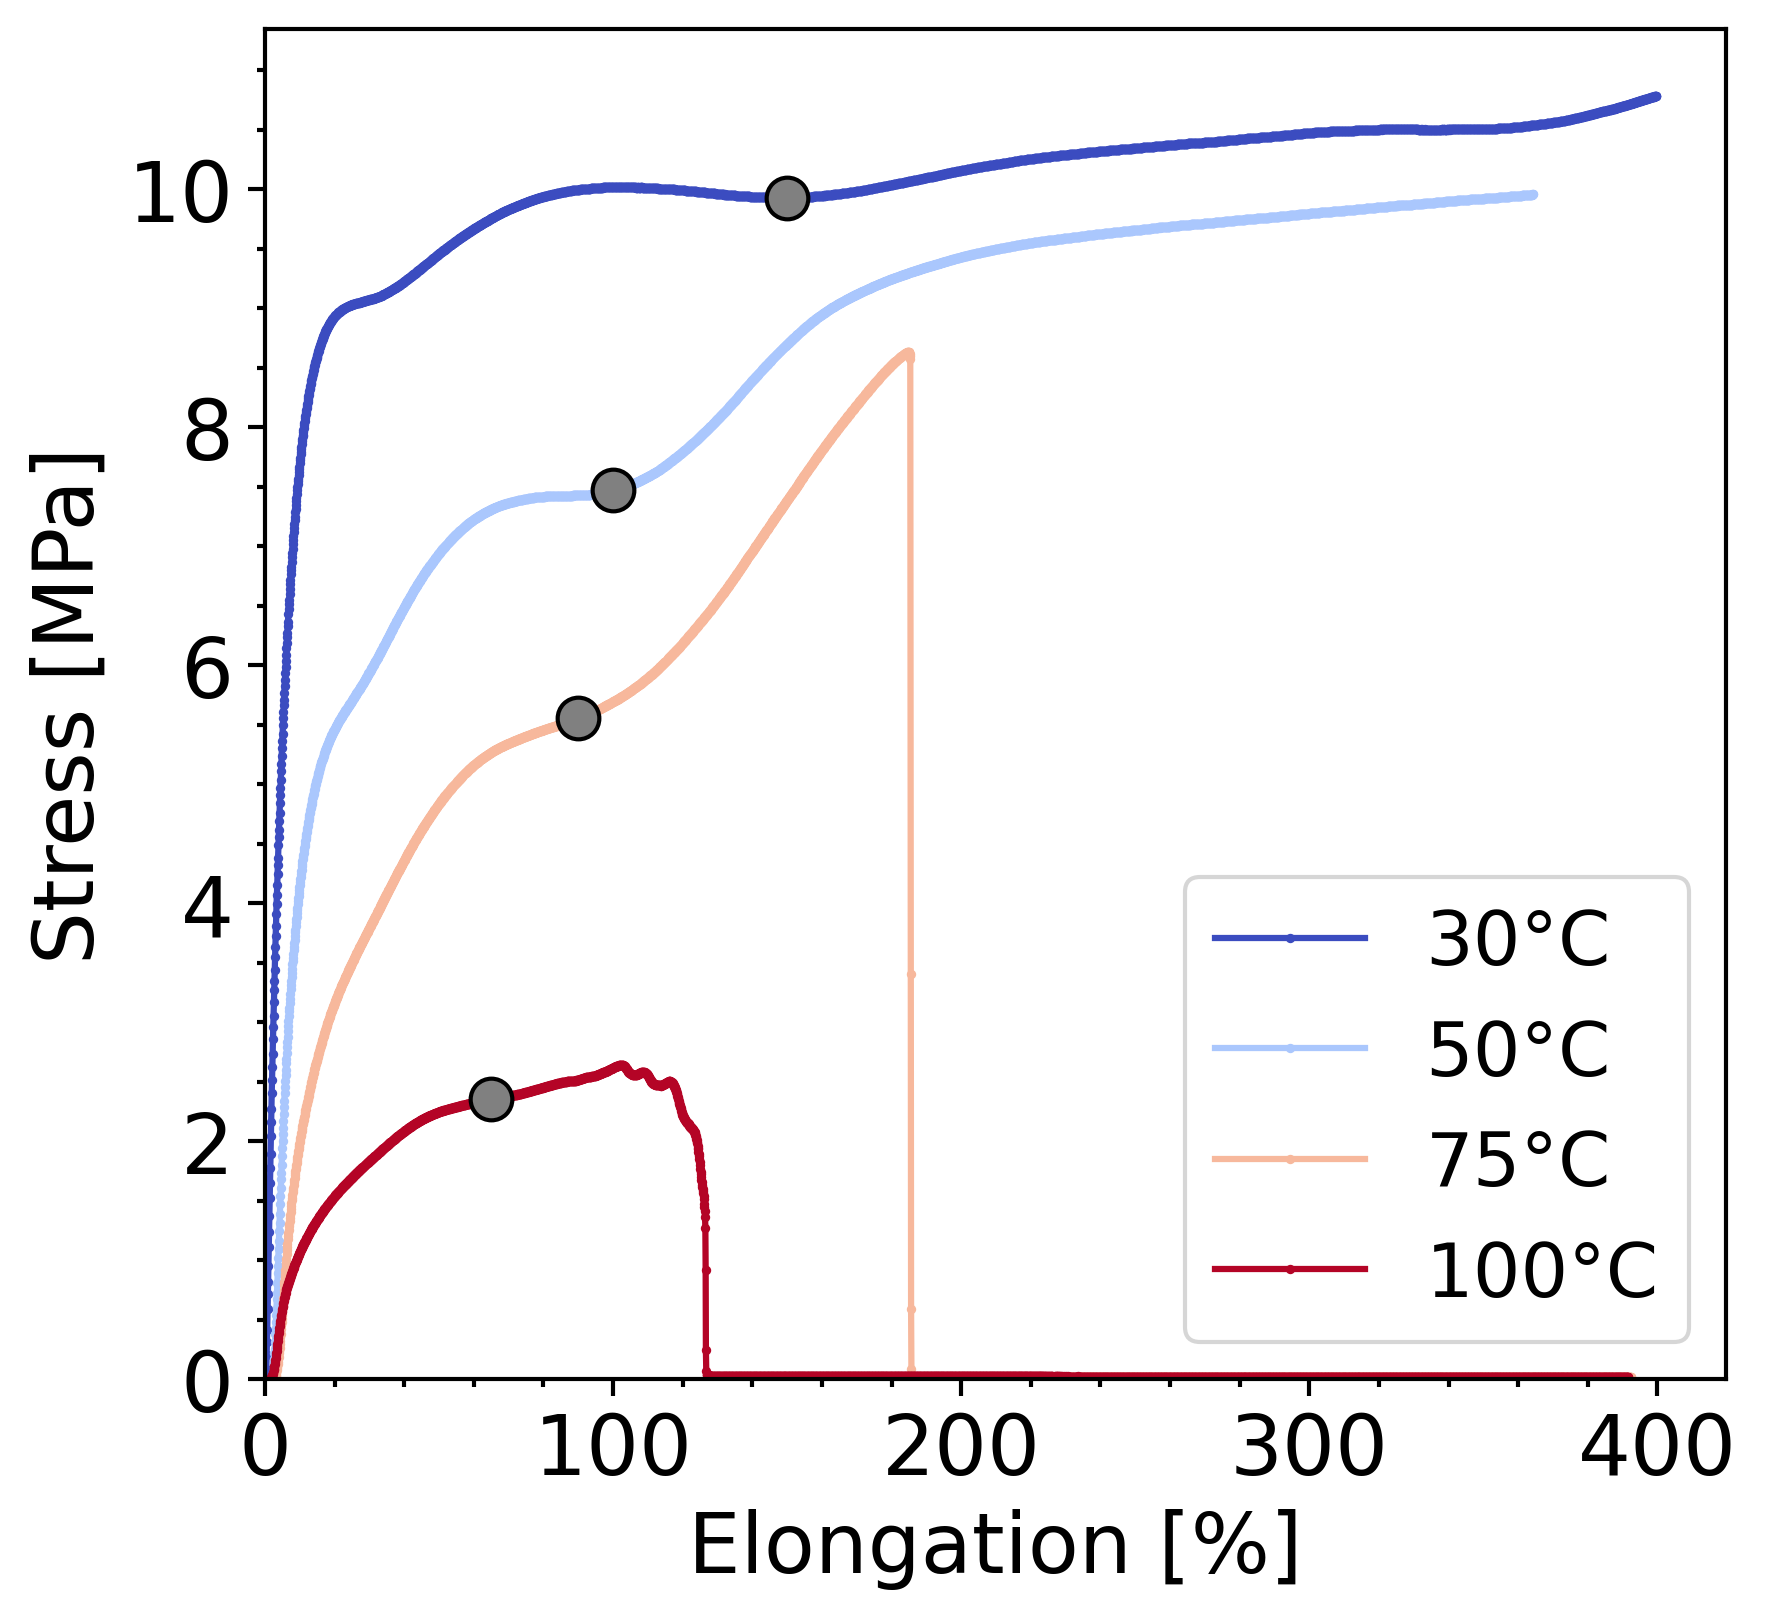

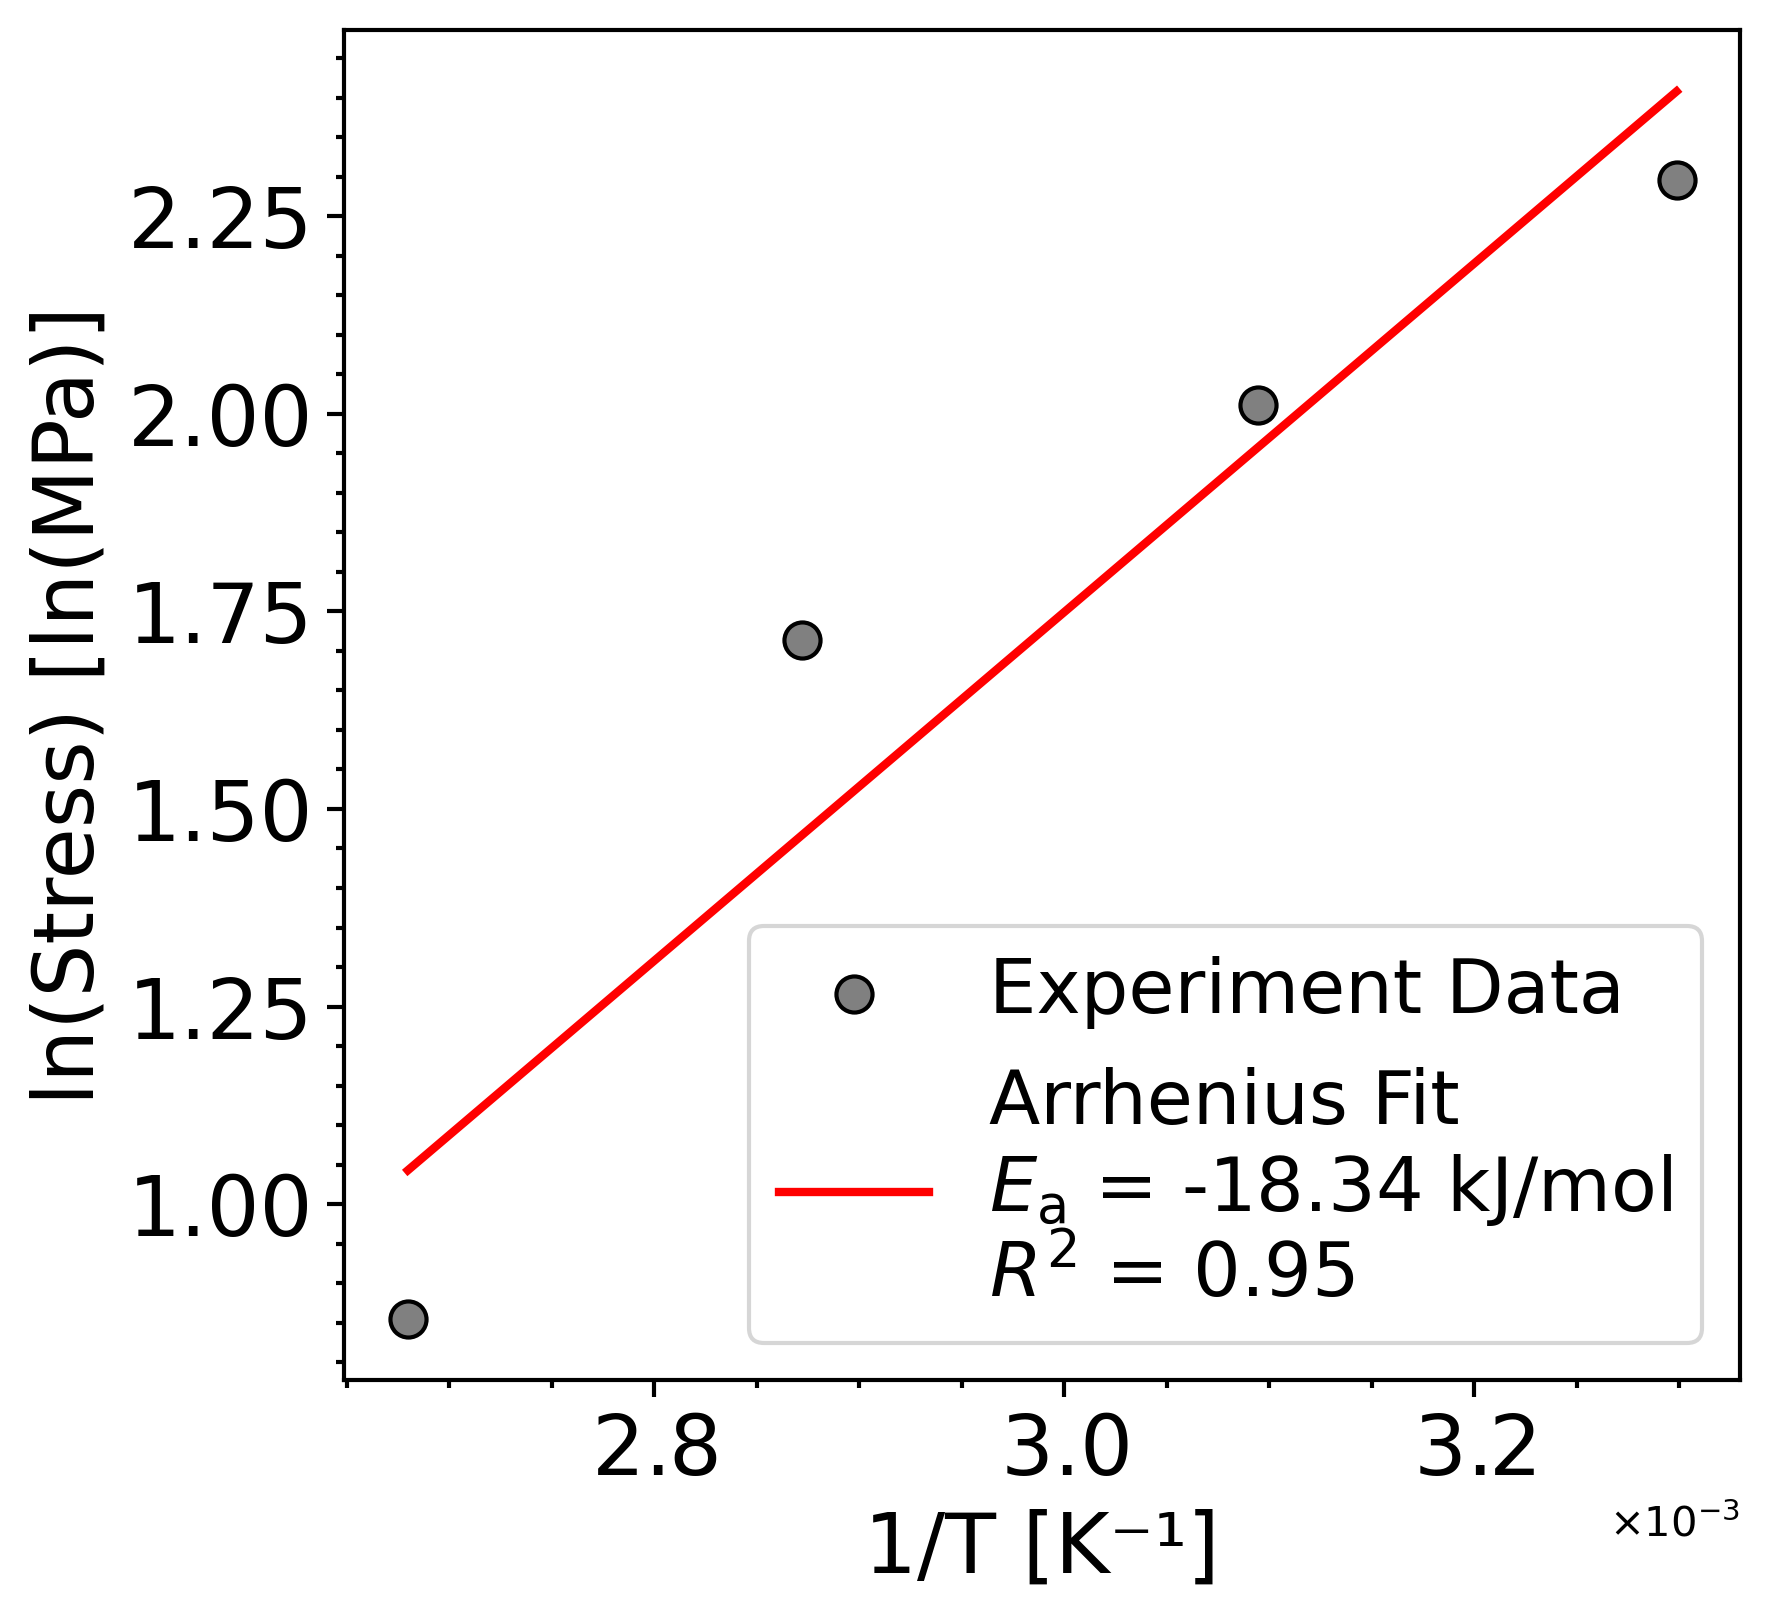

Activation energy: -18.34 ± 4.23 kJ/mol
Reduced chi-squared: 5.59e-02
Correlation coefficient (r): 0.950


In [431]:
from random import sample
from numpy import cross


base_path = r"/Users/akmaurya/OneDrive - Stanford/Data_01/Redesigned_Plastics/May_2025/linkam_stage/tensile_temperature_data"

file_keywords = [
    "Run8_LDPE_30C",
    "Run5_LDPE_50C",
    "Run6_LDPE_75C",
    "Run7_LDPE_100C",

]
sample_width = 10 #mm
sample_length = 0.51 #mm
cross_section = [sample_width * sample_length] * len(file_keywords)  # Cross-section in mm^2 for each run
# crosssection in m2
cross_section = [cs * 1e-6 for cs in cross_section]  # Convert mm^2 to m^2

enlogation_t = [150, 100, 90, 65]  # Elongation in percentage for each run

# Plot all force vs distance for the specified files



plot_all_force_vs_distance(base_path=base_path, file_keywords=file_keywords, figsize=(6, 5.5), dpi=300, cross_section=cross_section, enlogation_t=enlogation_t)





## LDPE - Gowda

📄 Plotting file: Run17_LDPE_30C_50ums 24-05-25 21-40-14-02Exported.xlsx


/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r', len(file_keywords))  # reversed so green=low, red=high
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm', len(file_keywords))  # reversed so green=low, red=high


📊 Plotting for:  at 30°C
📄 Plotting file: Run14_LDPE_50C_50ums 24-05-25 19-44-32-94Exported.xlsx
📊 Plotting for:  at 50°C
📄 Plotting file: Run15_LDPE_75C_50ums 24-05-25 20-21-41-31Exported.xlsx
📊 Plotting for:  at 75°C
📄 Plotting file: Run16_LDPE_100C_50ums 24-05-25 20-55-23-90Exported.xlsx
📊 Plotting for:  at 100°C


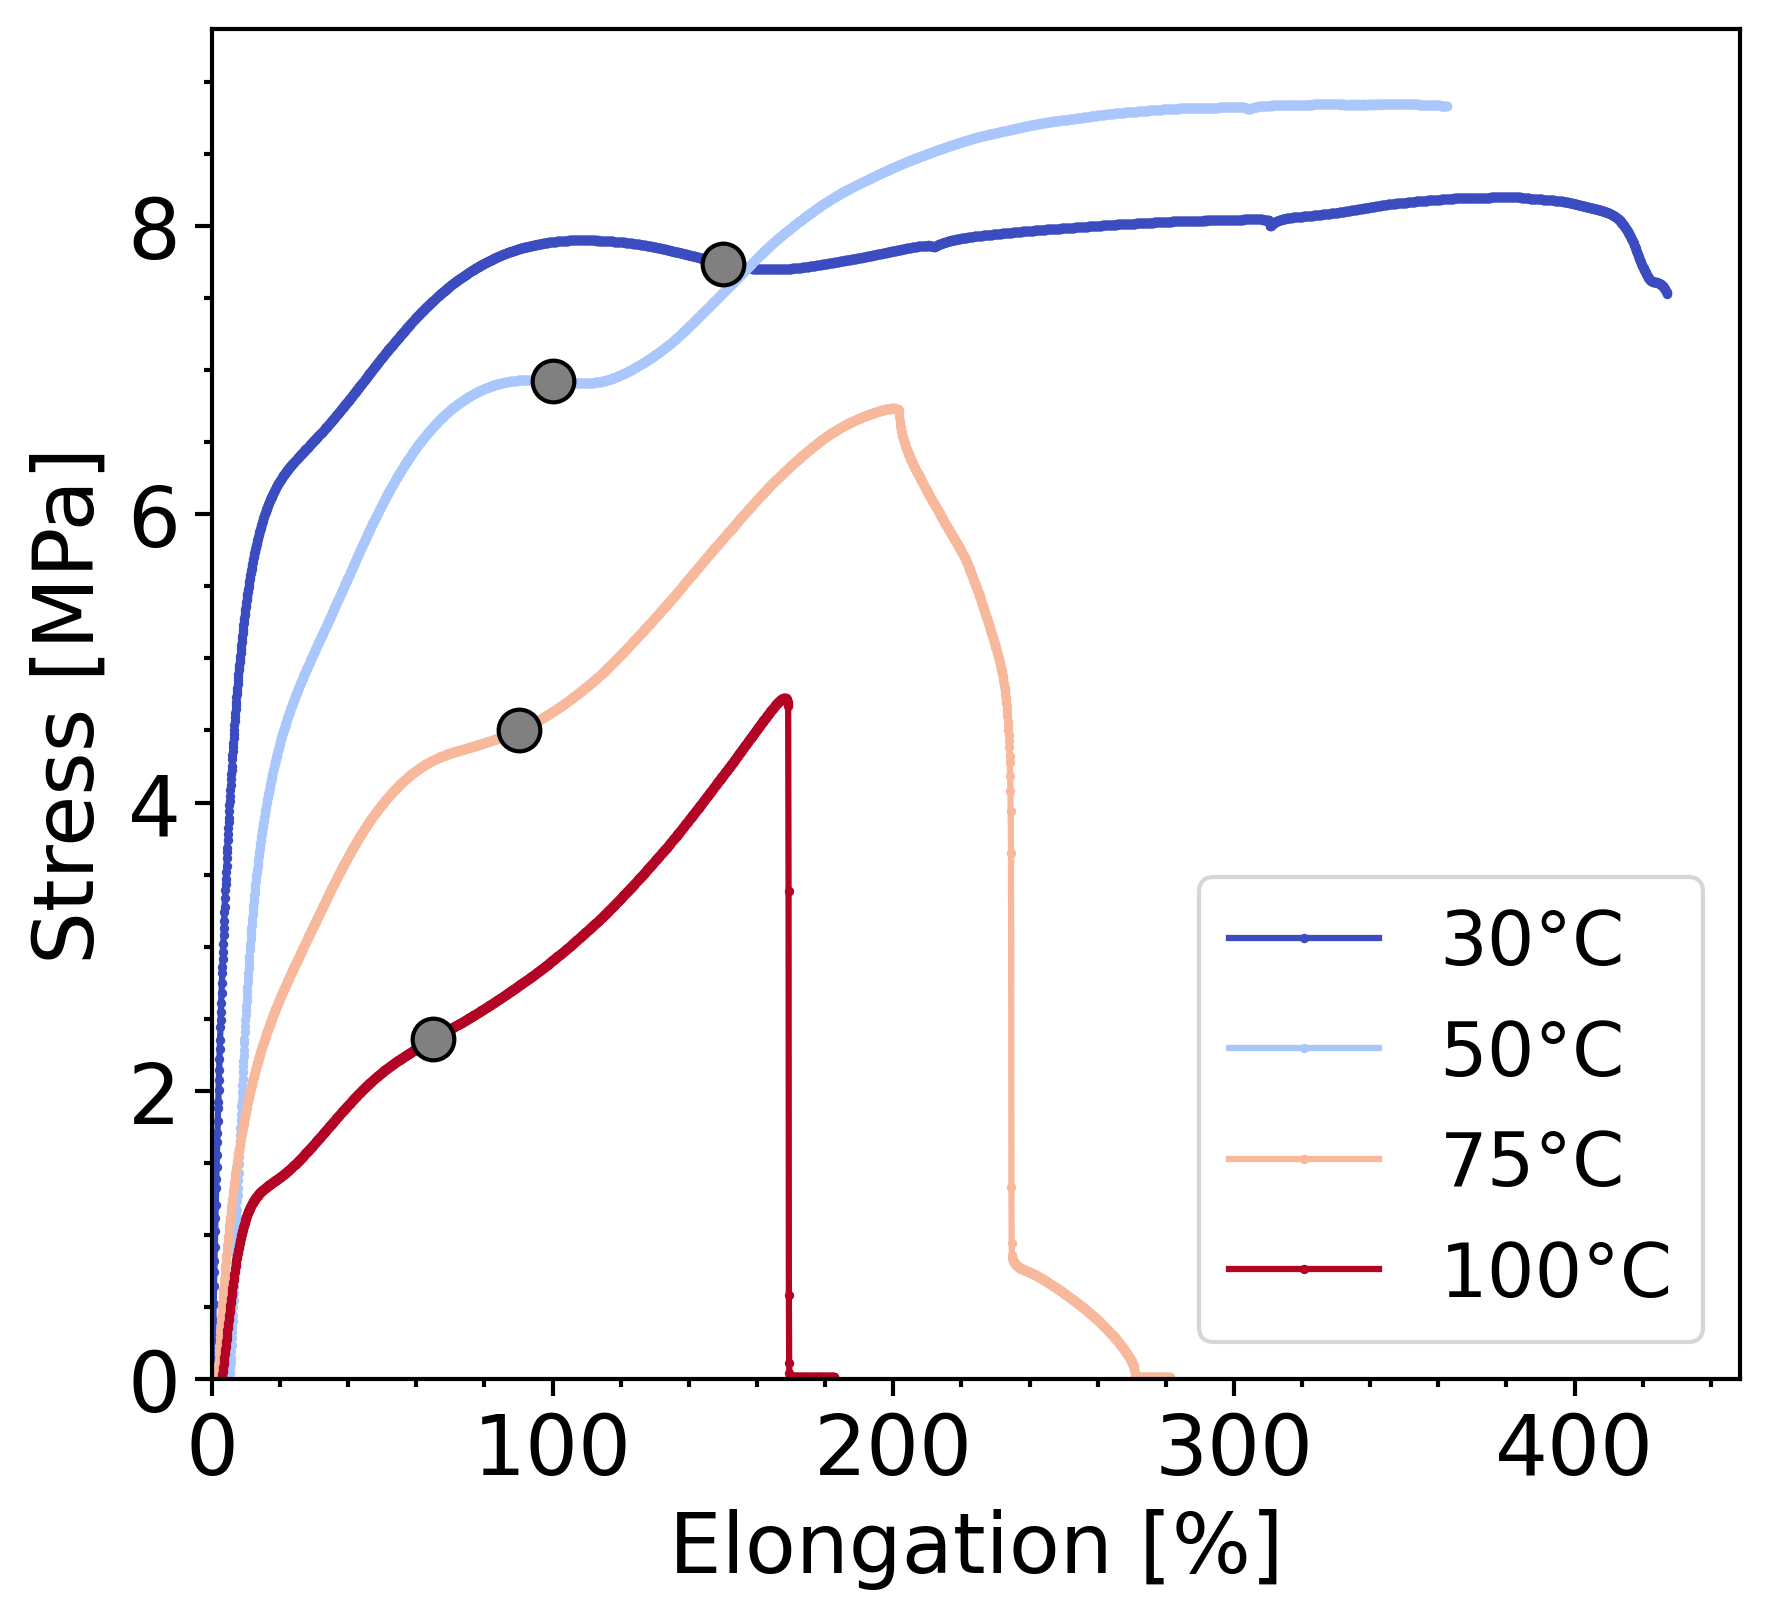

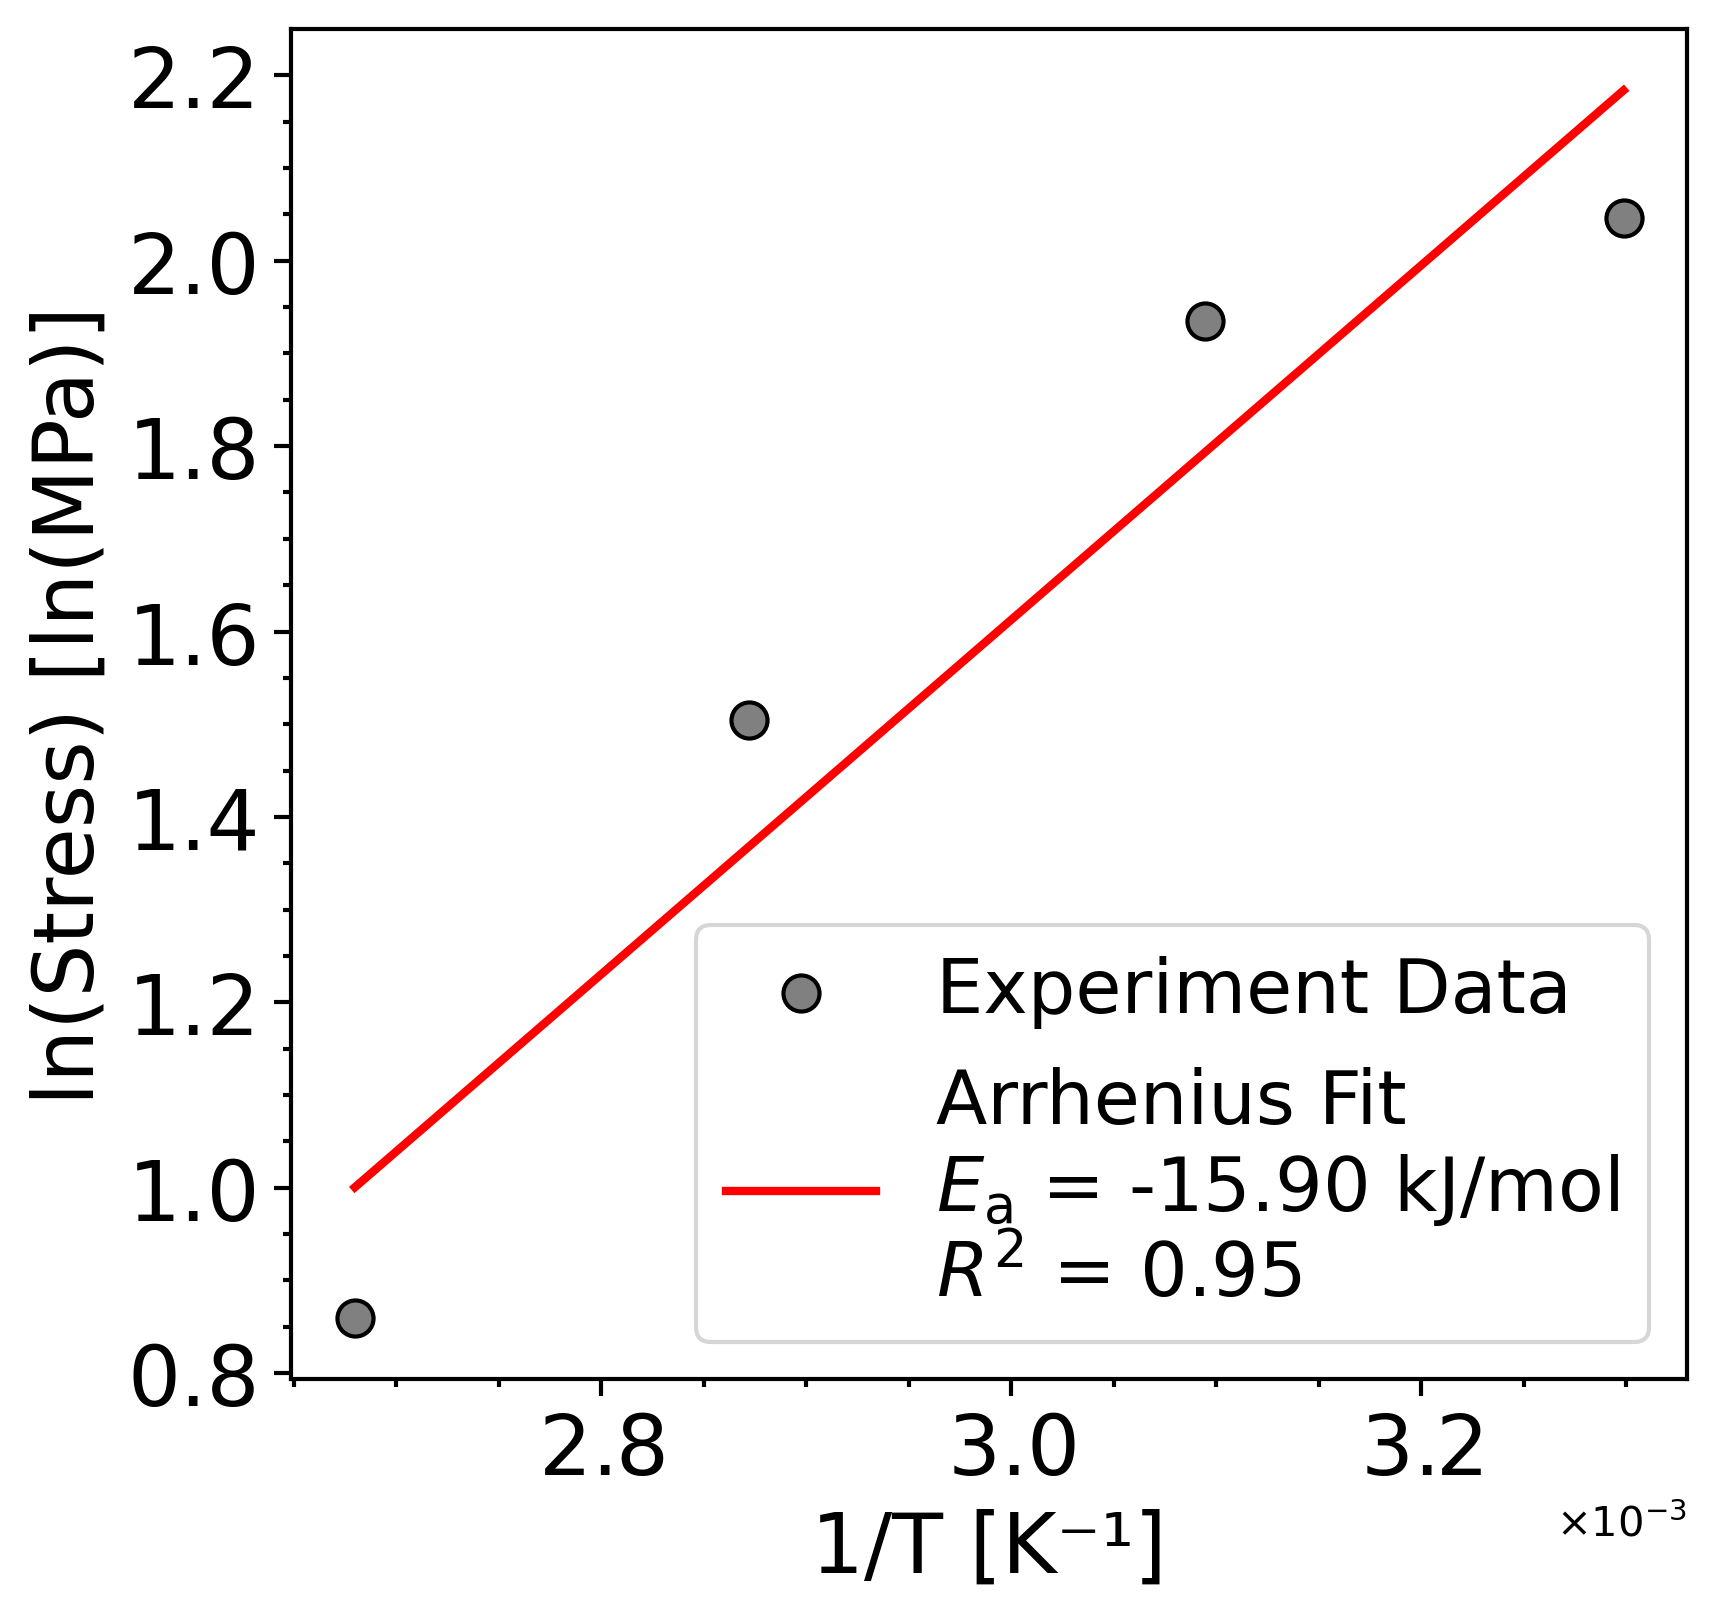

Activation energy: -15.90 ± 3.52 kJ/mol
Reduced chi-squared: 3.87e-02
Correlation coefficient (r): 0.950


In [432]:

file_keywords = [
    "Run17_LDPE_30C",
    "Run14_LDPE_50C",
    "Run15_LDPE_75C",
    "Run16_LDPE_100C",

]

sample_width = 10 #mm
sample_thickness =[1.130, 1.130,1.160, 1.150] #mm

cross_section = [sample_width * t for t in sample_thickness]  # Cross-section in mm^2 for each run
# crosssection in m2
cross_section = [cs * 1e-6 for cs in cross_section]  # Convert mm^2 to m^2

enlogation_t = [150, 100, 90, 65]  # Elongation in percentage for each run

plot_all_force_vs_distance(base_path=base_path, file_keywords=file_keywords, figsize=(6, 5.5), dpi=300, cross_section=cross_section, enlogation_t=enlogation_t)



## PHPD

📄 Plotting file: Run9_PHPD_30C_50ums 24-05-25 16-34-56-70Exported.xlsx


/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r', len(file_keywords))  # reversed so green=low, red=high
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_28471/4219434272.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm', len(file_keywords))  # reversed so green=low, red=high


📊 Plotting for:  at 30°C
📄 Plotting file: Run10_PHPD_45C_50ums 24-05-25 17-12-30-93Exported.xlsx
📊 Plotting for:  at 45°C
📄 Plotting file: Run11_PHPD_60C_50ums 24-05-25 17-51-10-14Exported.xlsx
📊 Plotting for:  at 60°C
📄 Plotting file: Run12_PHPD_75C_50ums 24-05-25 18-33-36-37Exported.xlsx
📊 Plotting for:  at 75°C


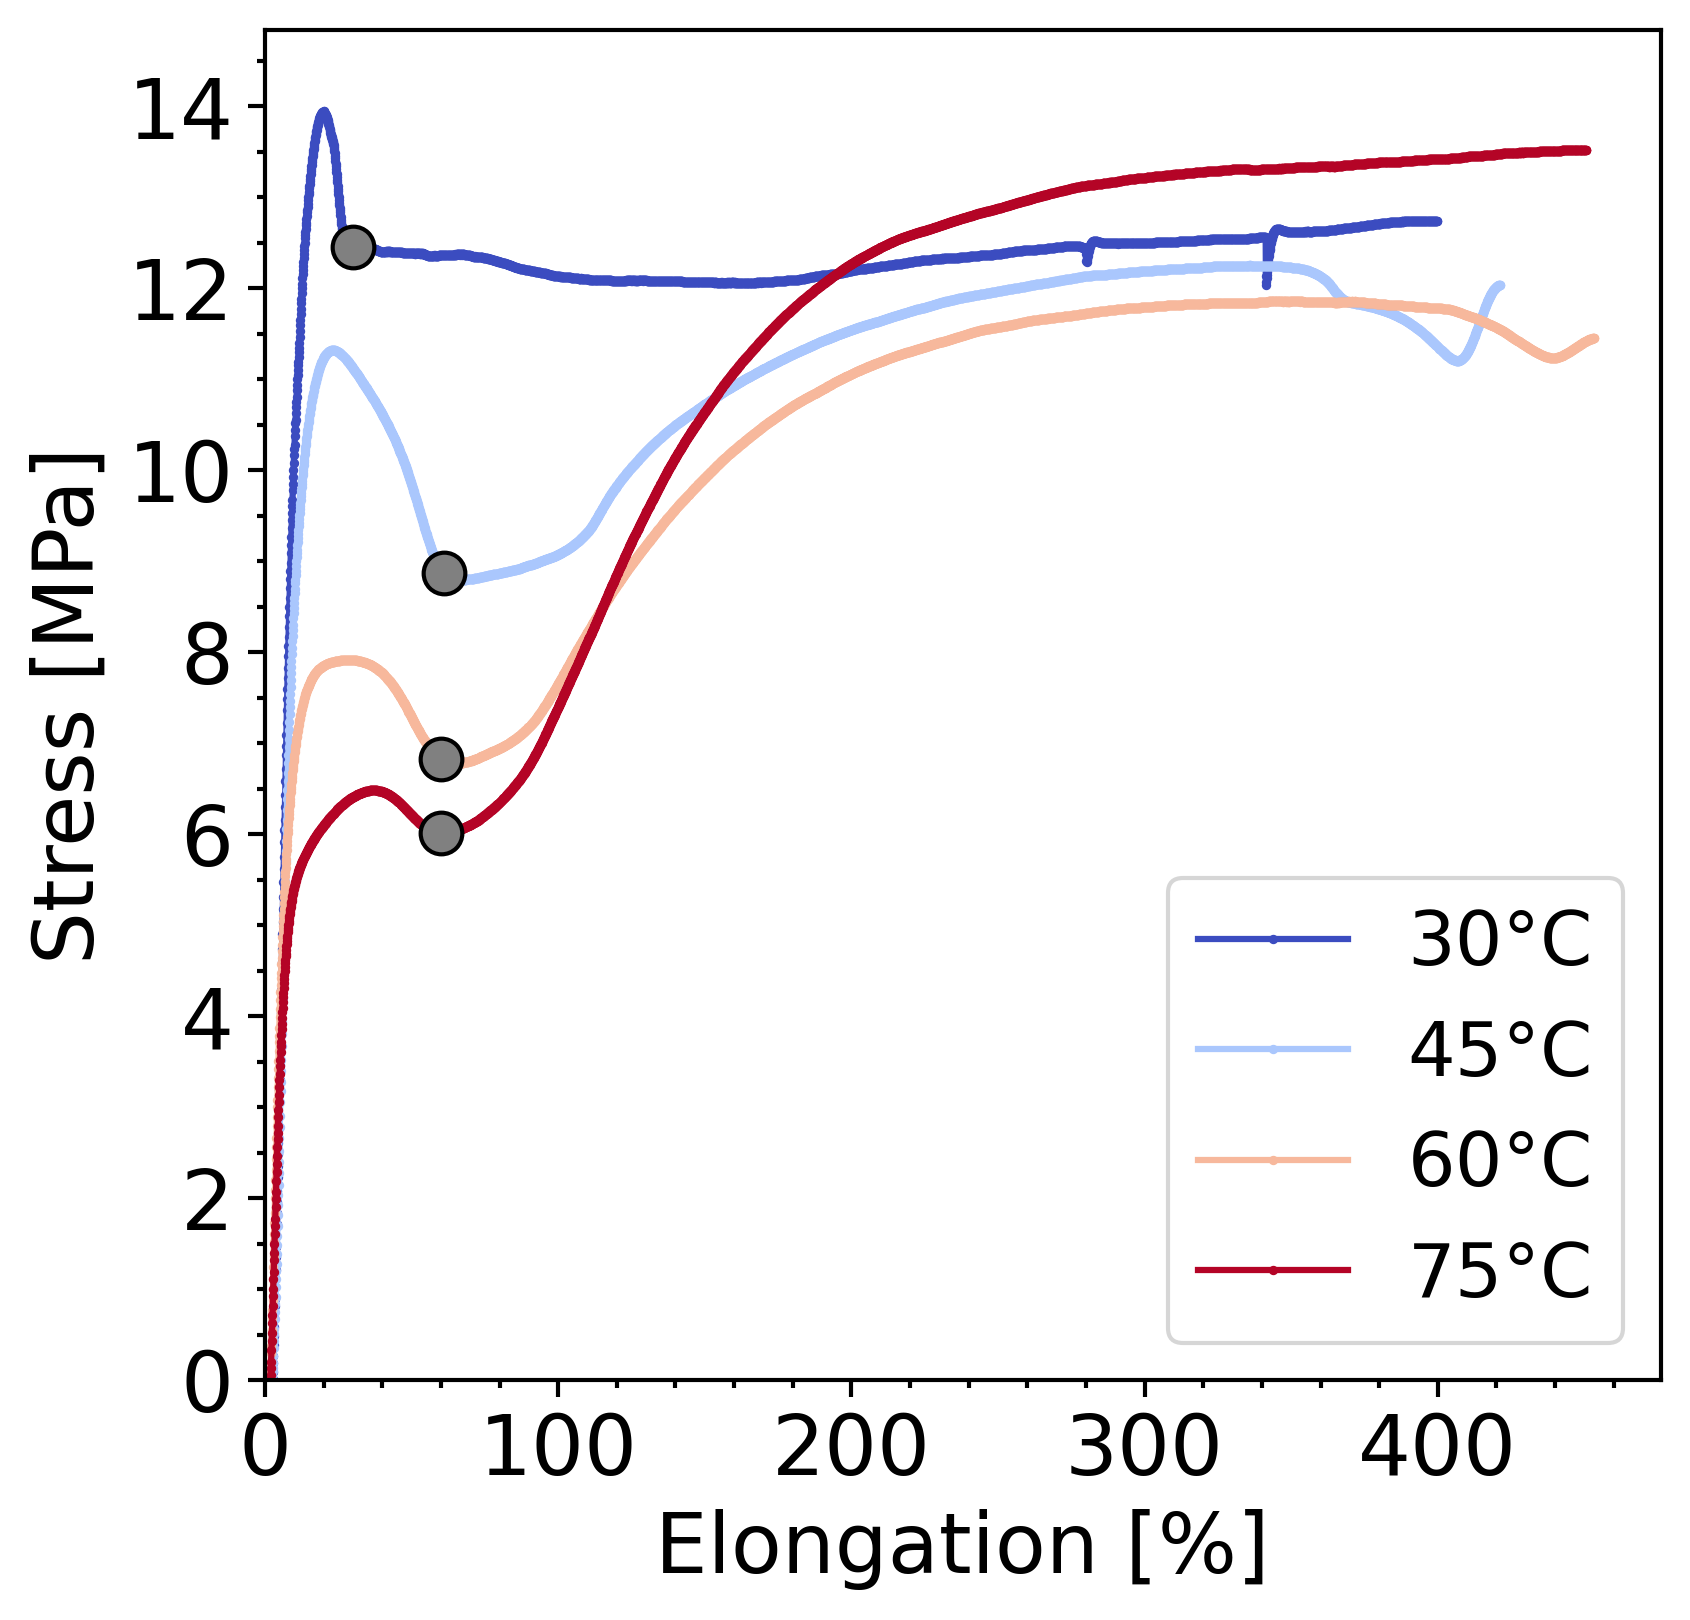

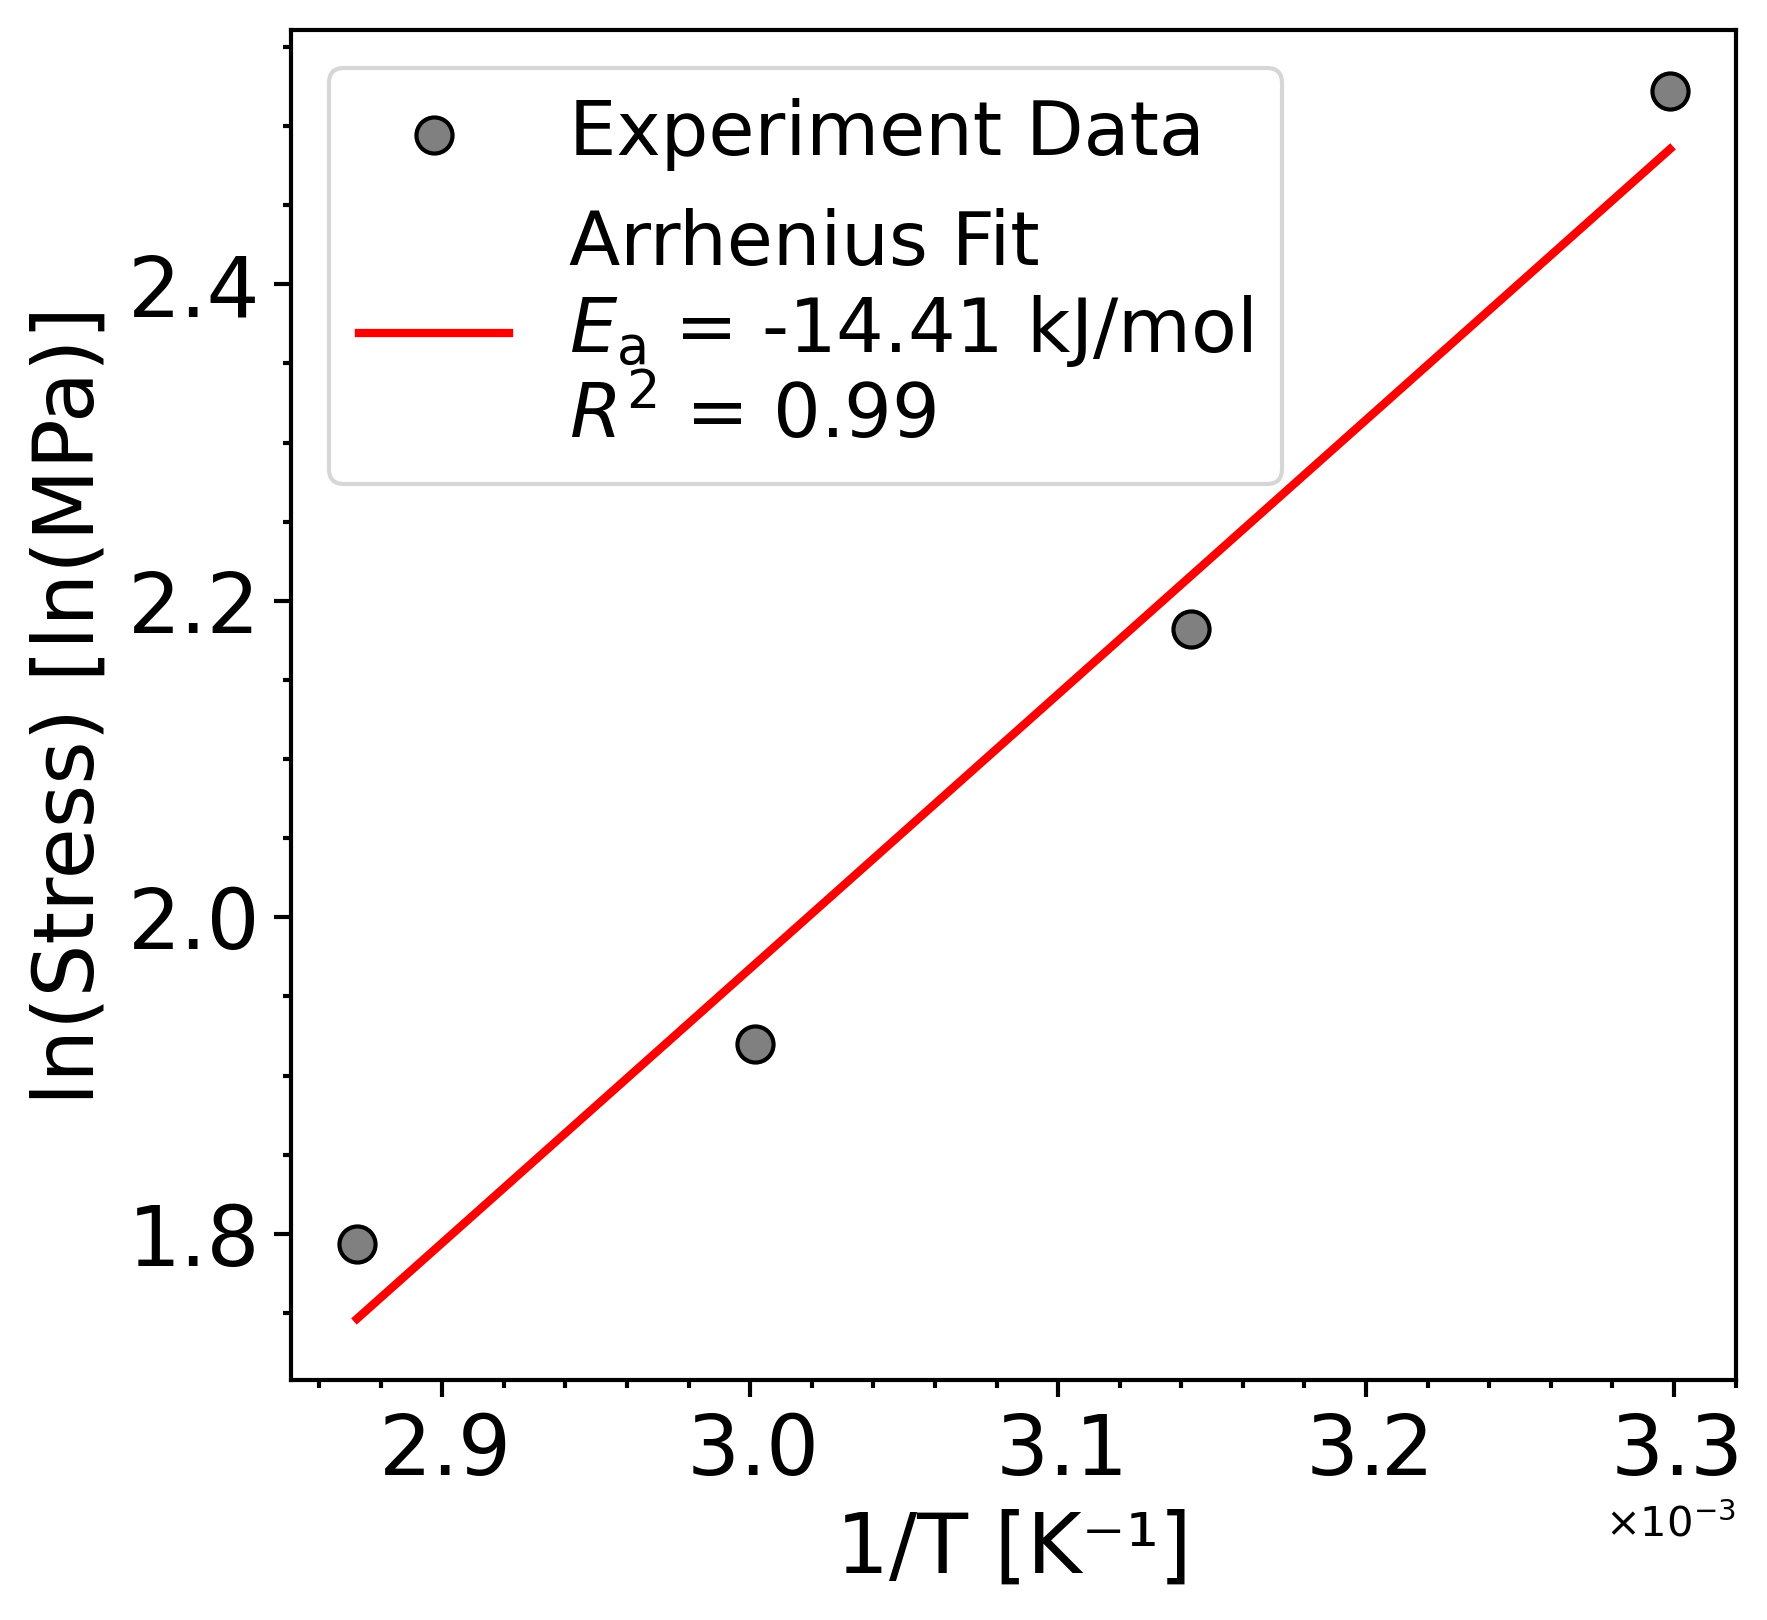

Activation energy: -14.41 ± 1.57 kJ/mol
Reduced chi-squared: 3.61e-03
Correlation coefficient (r): 0.990


In [433]:
file_keywords = [
    "Run9_PHPD_30C",
     "Run10_PHPD_45C",
     "Run11_PHPD_60C",
     "Run12_PHPD_75C",

]

sample_width = 10 #mm
sample_thickness = [1.090, 1.010, 1.070, 1.010] #mm

cross_section = [sample_width * t for t in sample_thickness]  # Cross-section in mm^2 for each run
# crosssection in m2
cross_section = [cs * 1e-6 for cs in cross_section]  # Convert mm^2 to m^2

#enlogation_t = [150, 100, 90, 65]  # Elongation in percentage for each run
enlogation_t = [30, 61, 60, 60]  # Elongation in percentage for each run
plot_all_force_vs_distance(base_path=base_path, file_keywords=file_keywords, figsize=(6, 5.5), dpi=300, cross_section=cross_section, enlogation_t=enlogation_t)
